# CUSTOMER LIFETIME VALUE:

### PARETO-NBD 
- This model looks at two things about each customer: 
    1. Will she buy soon and how often they buy (purchase frequency). 
    2. Wheter they're sill active. 

**How Does it Work?**
1. Poisson Process for Purchases : Customers buy at random times, but there's a pattern to how often they buy. 
2. Dropout (Churn) : The model assumes custoemrs can "drop out" (stop buying) at any time, and it uses Pareto distribution to guess when they might stop. 

**Data required**
* Frequency : How many times they've bought (not counting their first purchase)
* Recency : How long ago their last purchase was compared to their first purchase
* T (Time): The total time you've been watching this customer (from their first purchase to now)

### GAMMA-GAMMA MODEL 
It predicts the average order value (how much money a customer spends per purchase)

* Assumes that the amount a customer spends per purchase follows a pattern called a Gamma distribution

* The model looks at: 
    1. How much they've spent in total across all their purchase 
    2. How many purchases they've made

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 

warnings.filterwarnings('ignore')

In [2]:
import findspark 
from pyspark.sql import SparkSession

In [3]:
findspark.init()

spark = SparkSession.builder.appName("Customer Lifetime Value").getOrCreate()

customers = spark.read.csv(
    "../../final data/customer_features.csv", 
    header=True, 
    inferSchema=True
)

In [4]:
customers.show()

+-----------+-------------------+------------------+---------------+---------------------+-----------------------+----------------------------+-----------------------+------------------------+----------------------+------------------+--------------------------+--------------------------------+---------------------+---------------------+----------------------------------+--------------------------+----------------+-----------------------+---------------------+-----------------+--------------------------+--------------------------+---------------------------+
|customer_id|customer_first_date|customer_last_date|customer_tenure|customer_no_of_orders|customer_total_quantity|customer_average_order_value|customer_historical_clv|customer_diversity_score|customer_total_revenue|customer_is_repeat|customer_churn_probability|customer_avg_days_between_orders|customer_return_count|customer_return_value|customer_first_order_product_count|customer_first_order_value|customer_recency|customer_shipment_c

In [5]:
customers.columns

['customer_id',
 'customer_first_date',
 'customer_last_date',
 'customer_tenure',
 'customer_no_of_orders',
 'customer_total_quantity',
 'customer_average_order_value',
 'customer_historical_clv',
 'customer_diversity_score',
 'customer_total_revenue',
 'customer_is_repeat',
 'customer_churn_probability',
 'customer_avg_days_between_orders',
 'customer_return_count',
 'customer_return_value',
 'customer_first_order_product_count',
 'customer_first_order_value',
 'customer_recency',
 'customer_shipment_costs',
 'discount_junkie_score',
 'avg_discount_rate',
 'discount_order_value_ratio',
 'non_discounted_order_count',
 'discount_threshold_behavior']

In [6]:
# import spark modules needed 
from pyspark.sql import functions as f
from scipy.stats import poisson, gamma
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sb
import xarray as xr
from fastprogress.fastprogress import progress_bar
from lifetimes import ParetoNBDFitter

from pymc_marketing import clv
from pymc_marketing.prior import Prior

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [7]:
max_date = customers.select(f.max("customer_last_date")).collect()[0][0]

df = customers.select(
    "customer_id", 
    "customer_tenure",  # According to the calculation in SQL File this is the required `recency` (customer last date - customer first date)
    "customer_no_of_orders",
    "customer_average_order_value", # this is the monetary value column 
    "customer_first_date", 
    "customer_last_date"
).withColumn(
    "recency", f.col("customer_tenure")
).withColumn(
    "frequency", f.col("customer_no_of_orders") - 1
).withColumn(
    "monetary_value", f.col("customer_average_order_value")
).withColumn(
    "T", f.datediff(f.lit(max_date), f.col("customer_first_date"))
).withColumn(
    "recency", f.when(f.col("frequency") == 0, 0).otherwise(f.col("recency"))
).withColumn(
    "monetary_value", f.when(f.col("frequency") == 0, 0).otherwise(f.col("monetary_value"))
).drop("customer_first_date", "customer_last_date", "customer_tenure", "customer_no_of_orders", "customer_average_order_value")

In [8]:
df.show()

+-----------+-------+---------+--------------+----+
|customer_id|recency|frequency|monetary_value|   T|
+-----------+-------+---------+--------------+----+
|         10|      0|        0|           0.0| 819|
|        100|      0|        0|           0.0| 320|
|       1000|      0|        0|           0.0|1204|
|       1002|      0|        0|           0.0| 951|
|       1003|      0|        0|           0.0| 317|
|       1005|    176|        1|        466.72|1398|
|       1006|   1061|        2|        190.67|1070|
|       1008|      0|        0|           0.0|1316|
|       1009|    766|        1|       3501.34|1108|
|        101|    672|        1|       1004.18|1288|
|       1010|      0|        0|           0.0|1089|
|       1011|      0|        0|           0.0| 182|
|       1012|      0|        0|           0.0| 501|
|       1014|   1022|        4|        179.53|1401|
|       1015|   1157|        3|        1067.3|1200|
|       1016|    416|        1|       1022.96|1298|
|       1017

In [9]:
data = df.toPandas()
data.to_csv(r"C:\Users\takue\Documents\Predictive-Marketing-main\Predictive-Marketing-main\final data\model data\rfm_data.csv", index=False)

<Axes: title={'center': 'Customer Exposure'}, xlabel='Time since first purchase', ylabel='Customer'>

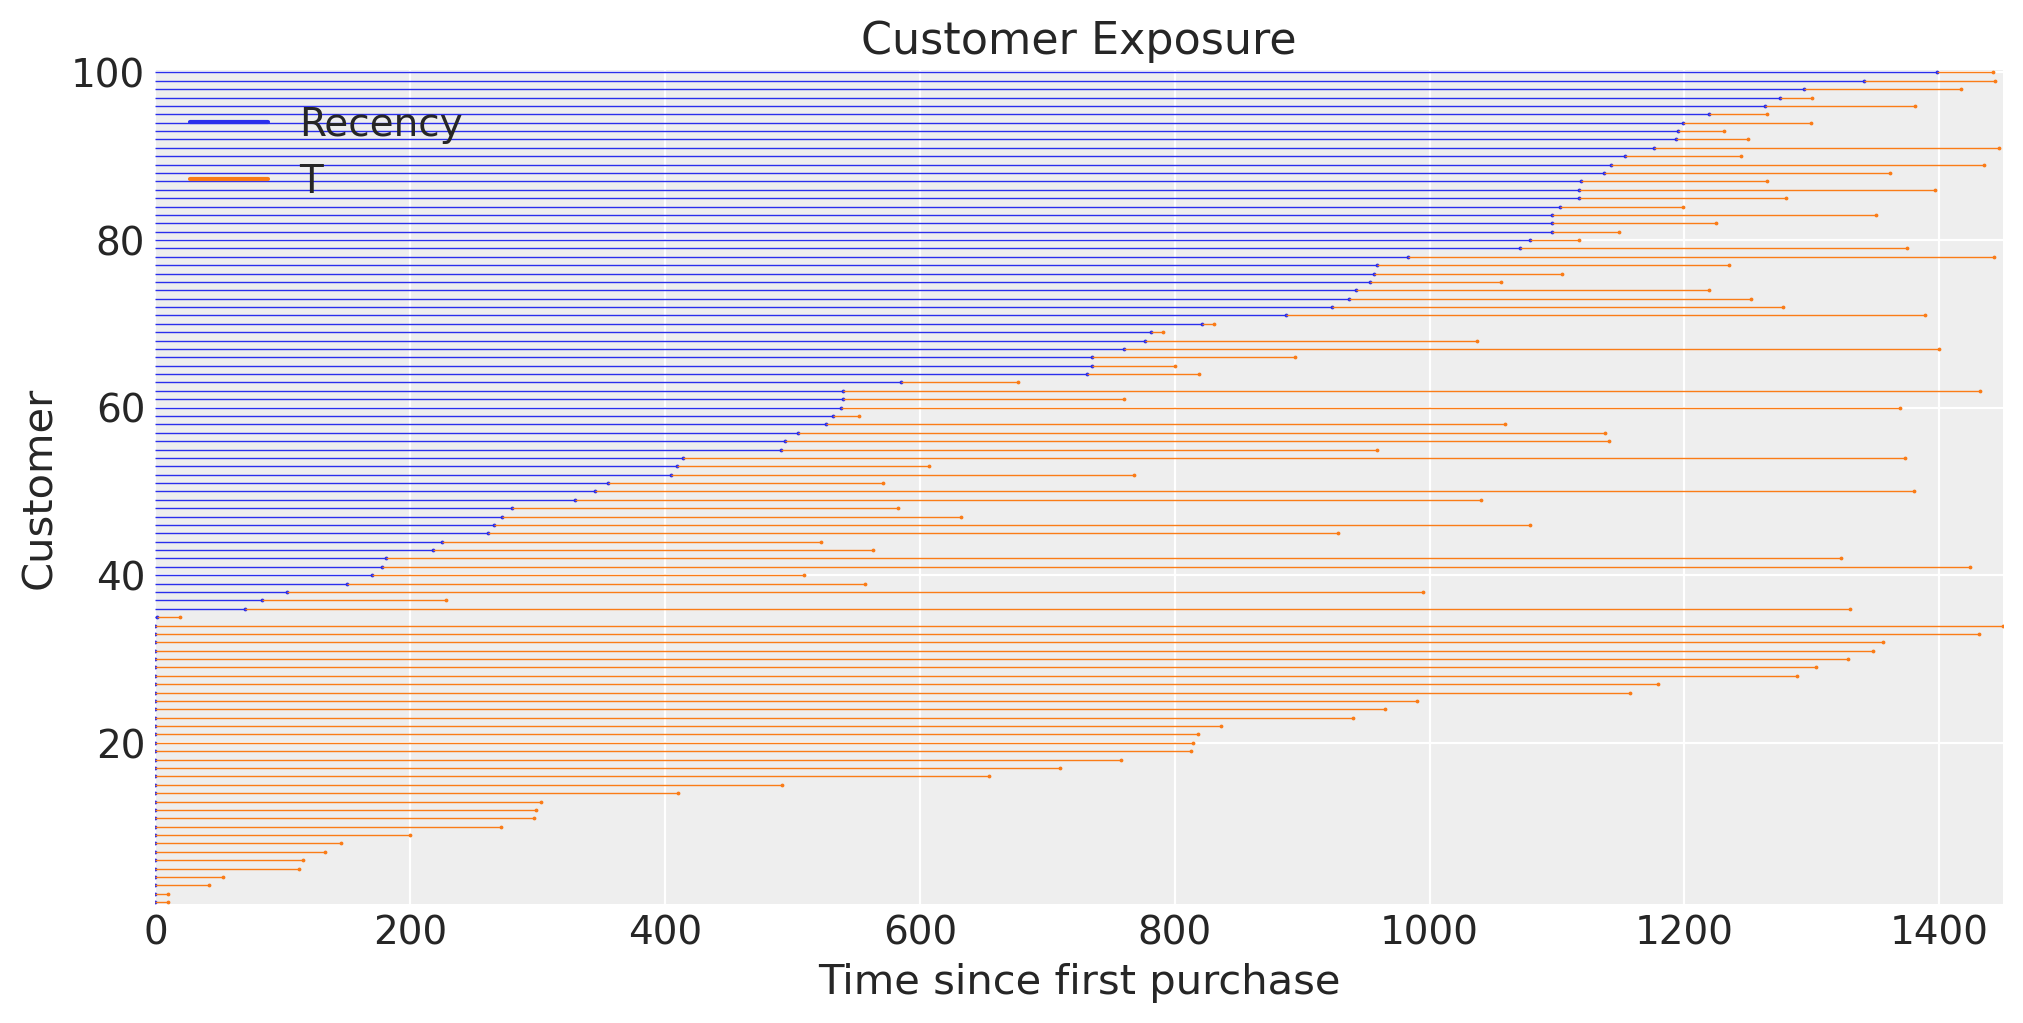

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
(
    data.sample(n=100, random_state=42)
    .sort_values(["recency", "T"])
    .pipe(clv.plot_customer_exposure, ax=ax, linewidth=0.5, size=0.75)
)

### CHECKING ASSUMPTIONS

We need to verify that the data aligns with teh assumptions of these models, specifically, that customer purchase evens follow a Poisson process and that monetary values follow Gamma Distribution. These assumptions are critical because the models rely on them ot make accurate predictions about customer behaviour.

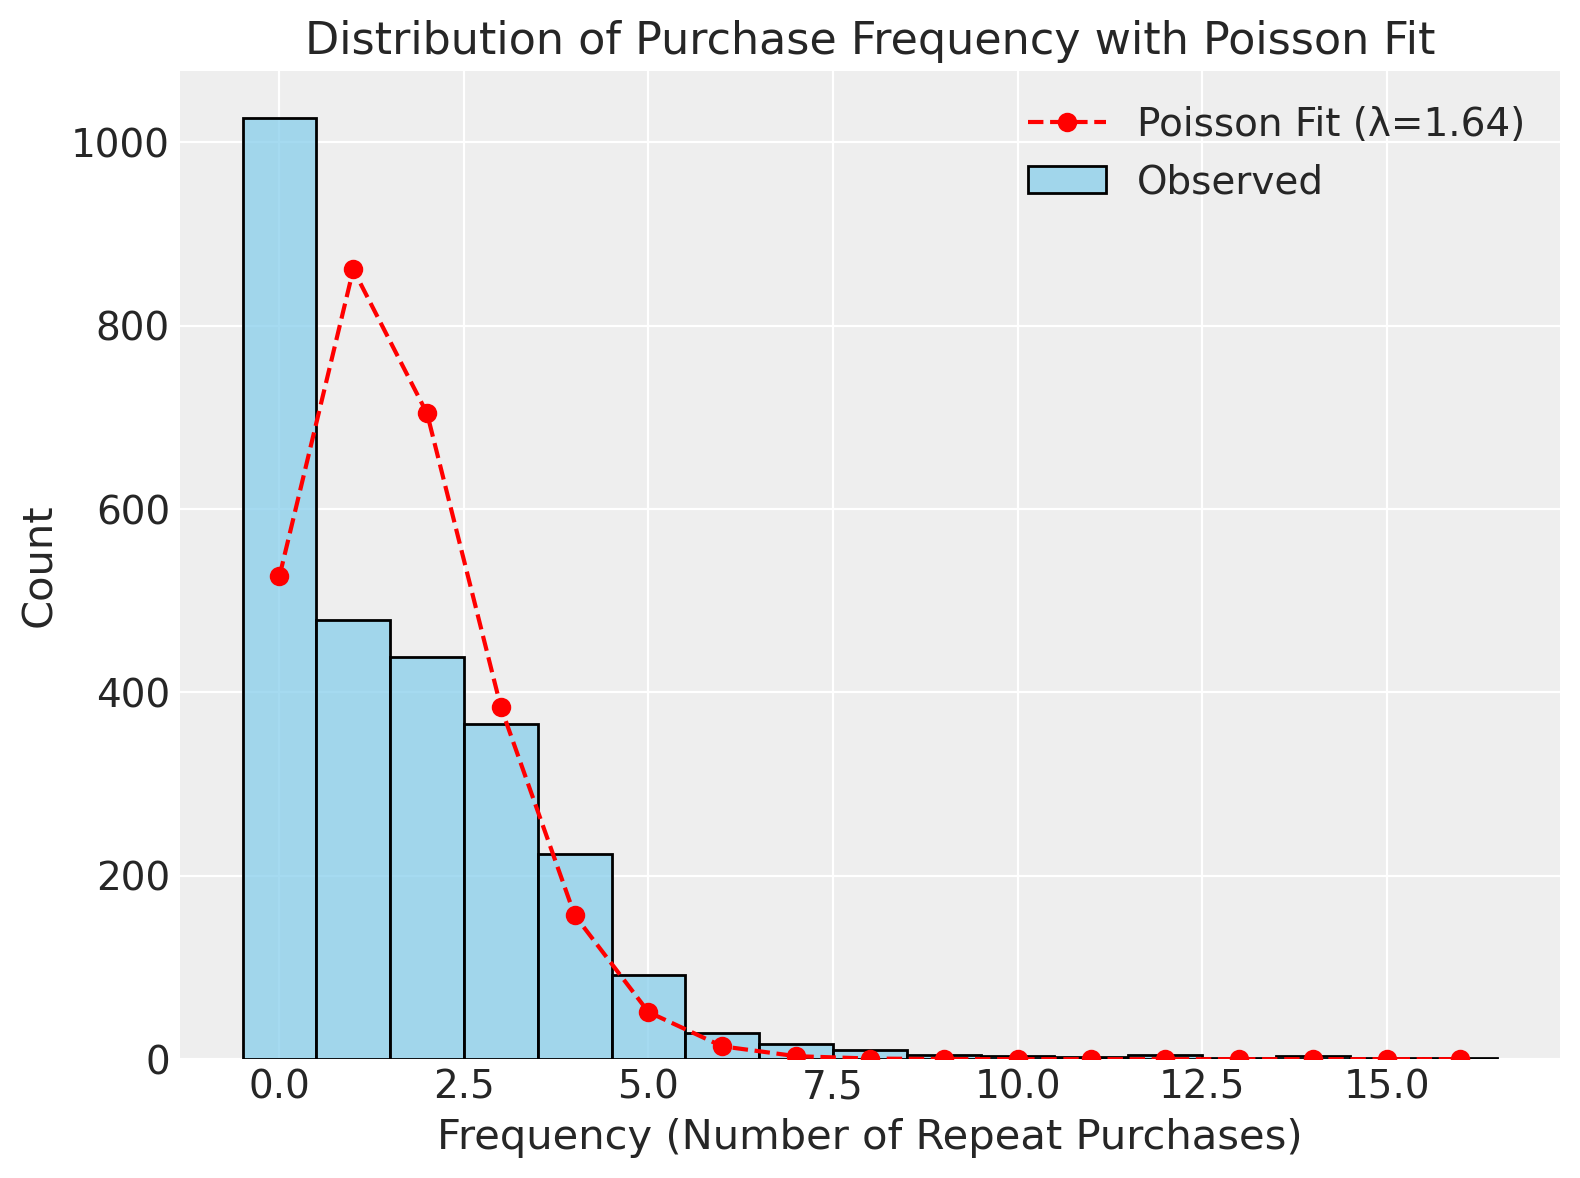

In [11]:
# Estimate lambda (mean frequency)
lam = data['frequency'].mean()

# Create the histogram
plt.figure(figsize=(8, 6))
sns.histplot(data['frequency'], bins=range(int(data['frequency'].max()) + 2), stat='count', discrete=True, color='skyblue', edgecolor='black', label='Observed')

# Create Poisson PMF values
x = np.arange(0, int(data['frequency'].max()) + 1)
poisson_probs = poisson.pmf(x, lam)
poisson_counts = poisson_probs * len(data)  # scale PMF to total count

# Plot Poisson fit
plt.plot(x, poisson_counts, 'r--', marker='o', label=f'Poisson Fit (λ={lam:.2f})')

# Labels and title
plt.title('Distribution of Purchase Frequency with Poisson Fit')
plt.xlabel('Frequency (Number of Repeat Purchases)')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()


The frequency data follows the Poisson distribution and our assumption has been passed

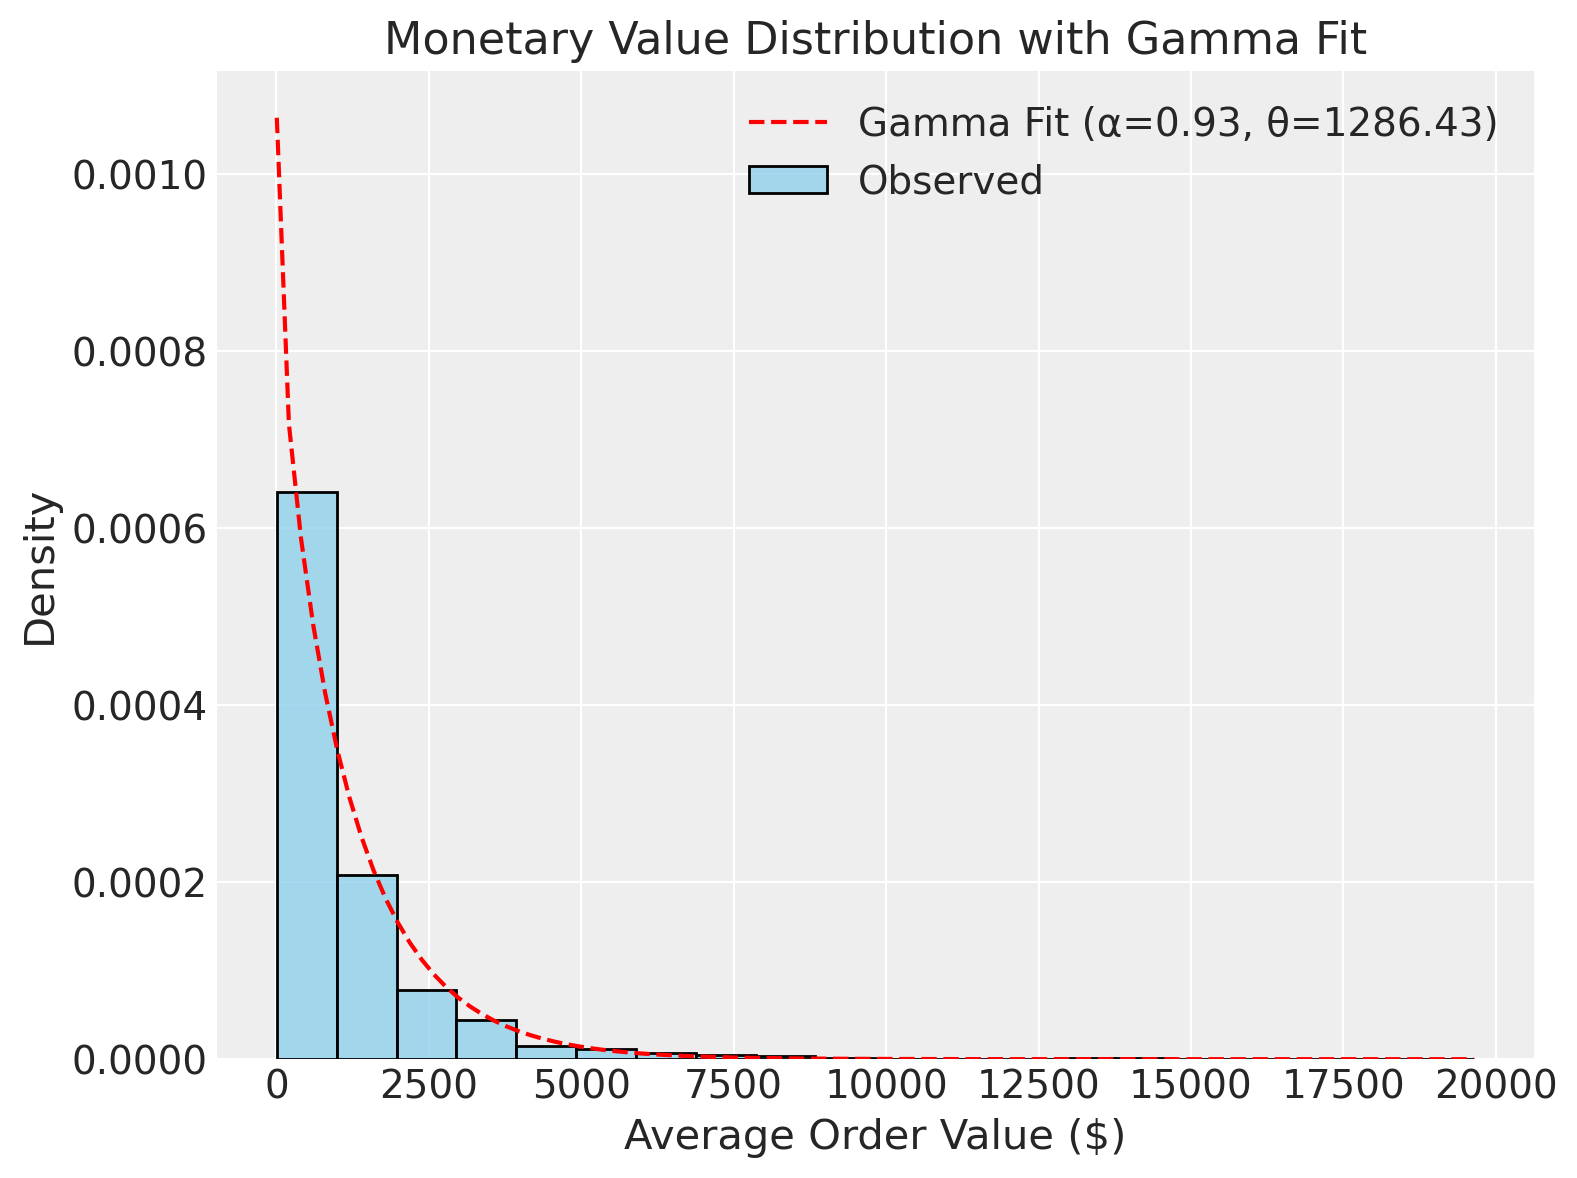

In [12]:
# Filter monetary values (repeat customers)
repeat_customers = data[data['frequency'] > 0]
monetary_values = repeat_customers['monetary_value']

# Estimate shape (α) and scale (θ) using MLE
shape, loc, scale = gamma.fit(monetary_values, floc=0)

# Plot histogram
plt.figure(figsize=(8, 6))
sns.histplot(monetary_values, bins=20, kde=False, stat='density', color='skyblue', edgecolor='black', label='Observed')

# Plot Gamma PDF
x = np.linspace(monetary_values.min(), monetary_values.max(), 100)
pdf = gamma.pdf(x, a=shape, loc=loc, scale=scale)
plt.plot(x, pdf, 'r--', label=f'Gamma Fit (α={shape:.2f}, θ={scale:.2f})')

# Labels
plt.title('Monetary Value Distribution with Gamma Fit')
plt.xlabel('Average Order Value ($)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


Both the assumptions have been passed that means we can proceed with our analysis

### Benchmark Model

In [13]:
freq = data['frequency'].values
rec = data['recency'].values 
T = data['T'].values 

pnbd_lt = ParetoNBDFitter()
pnbd_lt.fit(freq, rec, T)
pnbd_lt.params_.sort_index()

alpha    1.613041e+03
beta     3.610646e+03
r        2.852500e+00
s        3.386613e-10
dtype: float64

### INSIGHTS 
* r (Shape Parameter for purchases = 2.71)
    * Customers tend to make ~2-3 repeat purchases on average before potentially churning 
    * Higher r = more loyal, frequenty buyers 
    * I think this is idea given this is a furniture and technology selling company though they have office supplies, these cannot be compared to grocaries. However we can focus on increasing purchase frequency through complementary products (e.g. tech accessories with furnitute)

* alpha (Scale Parameter for Purchases = 1,613.07)
    * Purchase happen very infrequenctly (the high number streches out the time between purchases)
    * Customers buy every ~1613 days (4.4 years) on average. 
    * As specified before this can be expected due to the nature of the business. 

* s (Shape Parameter for churn = ~0.000000000616)
    * Nearly all customer churn immediately after their first purchase 
    * s close to 0 = extremely high churn rate 

* beta (Scale Parameter for churn = 4,512.20)
    * Even accounting for s, churn happens very slowly (contradicting s).
    * sign the model struggled to fit your data. Data may contain many one-time purchasers with few repeat buyers. Model may be overfitting to sparse repeat-purchase data

MLE tries to find the values of the parameters that maximize the likelihood of observing your data — without assuming anything before seeing the data. We are going to fit the same model using Bayesian Approach (MAP) now adding prior knowledge. Find parameter values that fit the data AND match your prior beliefs.

In [14]:
flat_config = {
    "r": Prior("HalfFlat"),
    "alpha": Prior("HalfFlat"),
    "s": Prior("HalfFlat"),
    "beta": Prior("HalfFlat"),
}

pnbd_pymc = clv.ParetoNBDModel(data=data, model_config=flat_config)

In [15]:
pnbd_pymc.build_model()  # optional step
pnbd_pymc

Pareto/NBD
            alpha ~ HalfFlat()
             beta ~ HalfFlat()
                r ~ HalfFlat()
                s ~ HalfFlat()
recency_frequency ~ ParetoNBD(r, alpha, s, beta, <constant>)

In [16]:
idata_map = pnbd_pymc.fit(method="map")

Output()

In [17]:
flat_fit = pnbd_pymc.fit_summary()
print(flat_fit)

alpha    1616.297
beta        3.371
r           2.860
s           0.000
Name: value, dtype: float64


Due to churn scale dropping drastically I can say that the map model does well as the contradiction issue has been reduced.

With prior distributions, we can inform model fitting with our own subjective domain knowledge, and even improve the speed of model fits. The default prior configuration for ParetoNBDModel works well for a variety of use cases:

In [18]:
pnbd_map = clv.ParetoNBDModel(data=data)
pnbd_map.build_model()
pnbd_map

Pareto/NBD
            alpha ~ Weibull(2, 10)
             beta ~ Weibull(2, 10)
                r ~ Weibull(2, 1)
                s ~ Weibull(2, 1)
recency_frequency ~ ParetoNBD(r, alpha, s, beta, <constant>)

### Prior and Posterior Predictive Checks

PPCs allow us to check the efficiency of our priors, and the peformance of the fitted posteriors. PPCs aren’t usually an option with MAP fitted models, but here we’re actually sampling from the latent and Gamma distributions, so PPCs are possible for ParetoNBDModel regardless of the fit method!

Sampling: [alpha, beta, r, recency_frequency, s]
Sampling: [alpha, beta, r, recency_frequency, s]


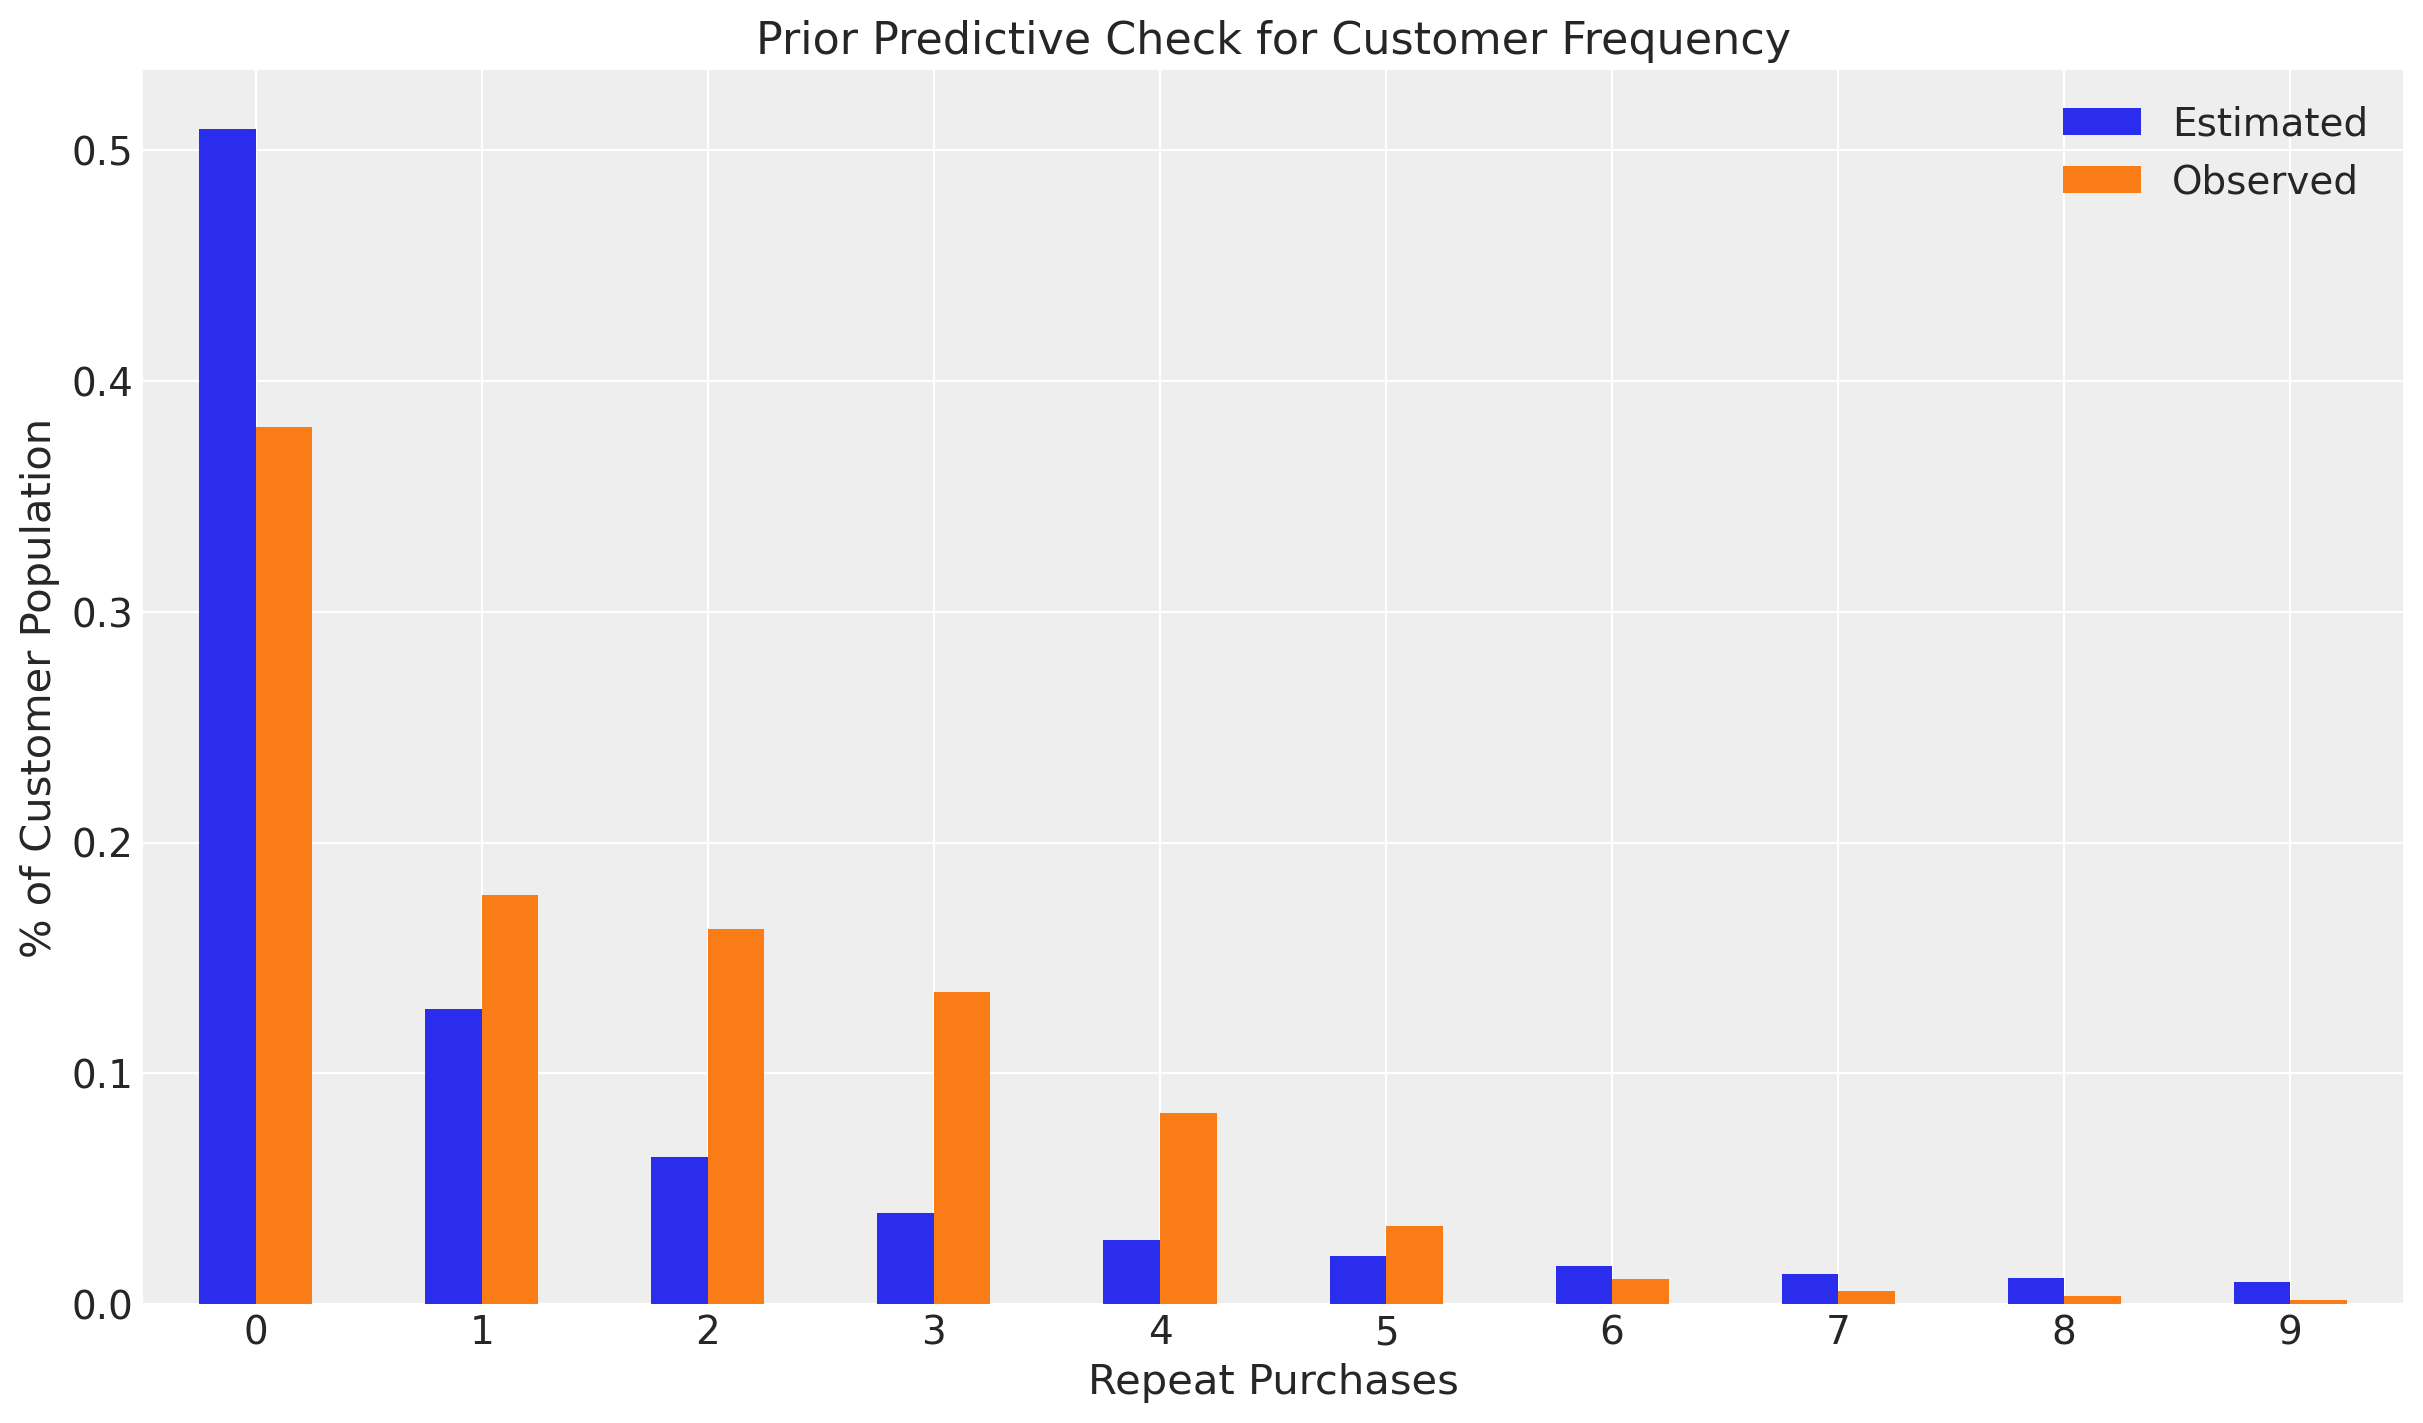

In [19]:
with pnbd_map.model:
    prior_idata = pm.sample_prior_predictive(random_seed=45, draws=1)

obs_freq = prior_idata.observed_data["recency_frequency"].sel(obs_var="frequency")
ppc_freq = prior_idata.prior_predictive["recency_frequency"].sel(obs_var="frequency")[
    0
][0]

# PPC histogram plot
clv.plot_expected_purchases_ppc(pnbd_map, ppc="prior");

### Key Observations from the PPC:
1. **Underestimation for Low Frequencies (Up to 5 Purchases)**
    * The model underestimates the number of repeat purchases for customers with up to 5 transactions. This suggests that the prior distributions may not fully capture the behavior of customers with lower purchase frequencies, which could be a significant portion of the customer base in many businesses.
    * From a business perspective, this underestimation could be beneficial as it encourages a conservative approach, prompting companies to rethink marketing strategies to boost repeat purchases among these customers.
2. **Overestimation for Higher Frequencies (After 6 Purchases):**
    * For customers with more than 6 repeat purchases, the model overestimates the frequency. This is less ideal from a business standpoint because it may lead to overly optimistic assumptions about high-frequency customers, potentially misguiding resource allocation or marketing efforts targeting these customers.
    * Overestimating high-frequency purchases could result in misaligned expectations for customer lifetime value (CLV) or retention strategies.

Output()

Sampling: [recency_frequency]


Output()

Sampling: [recency_frequency]


Output()

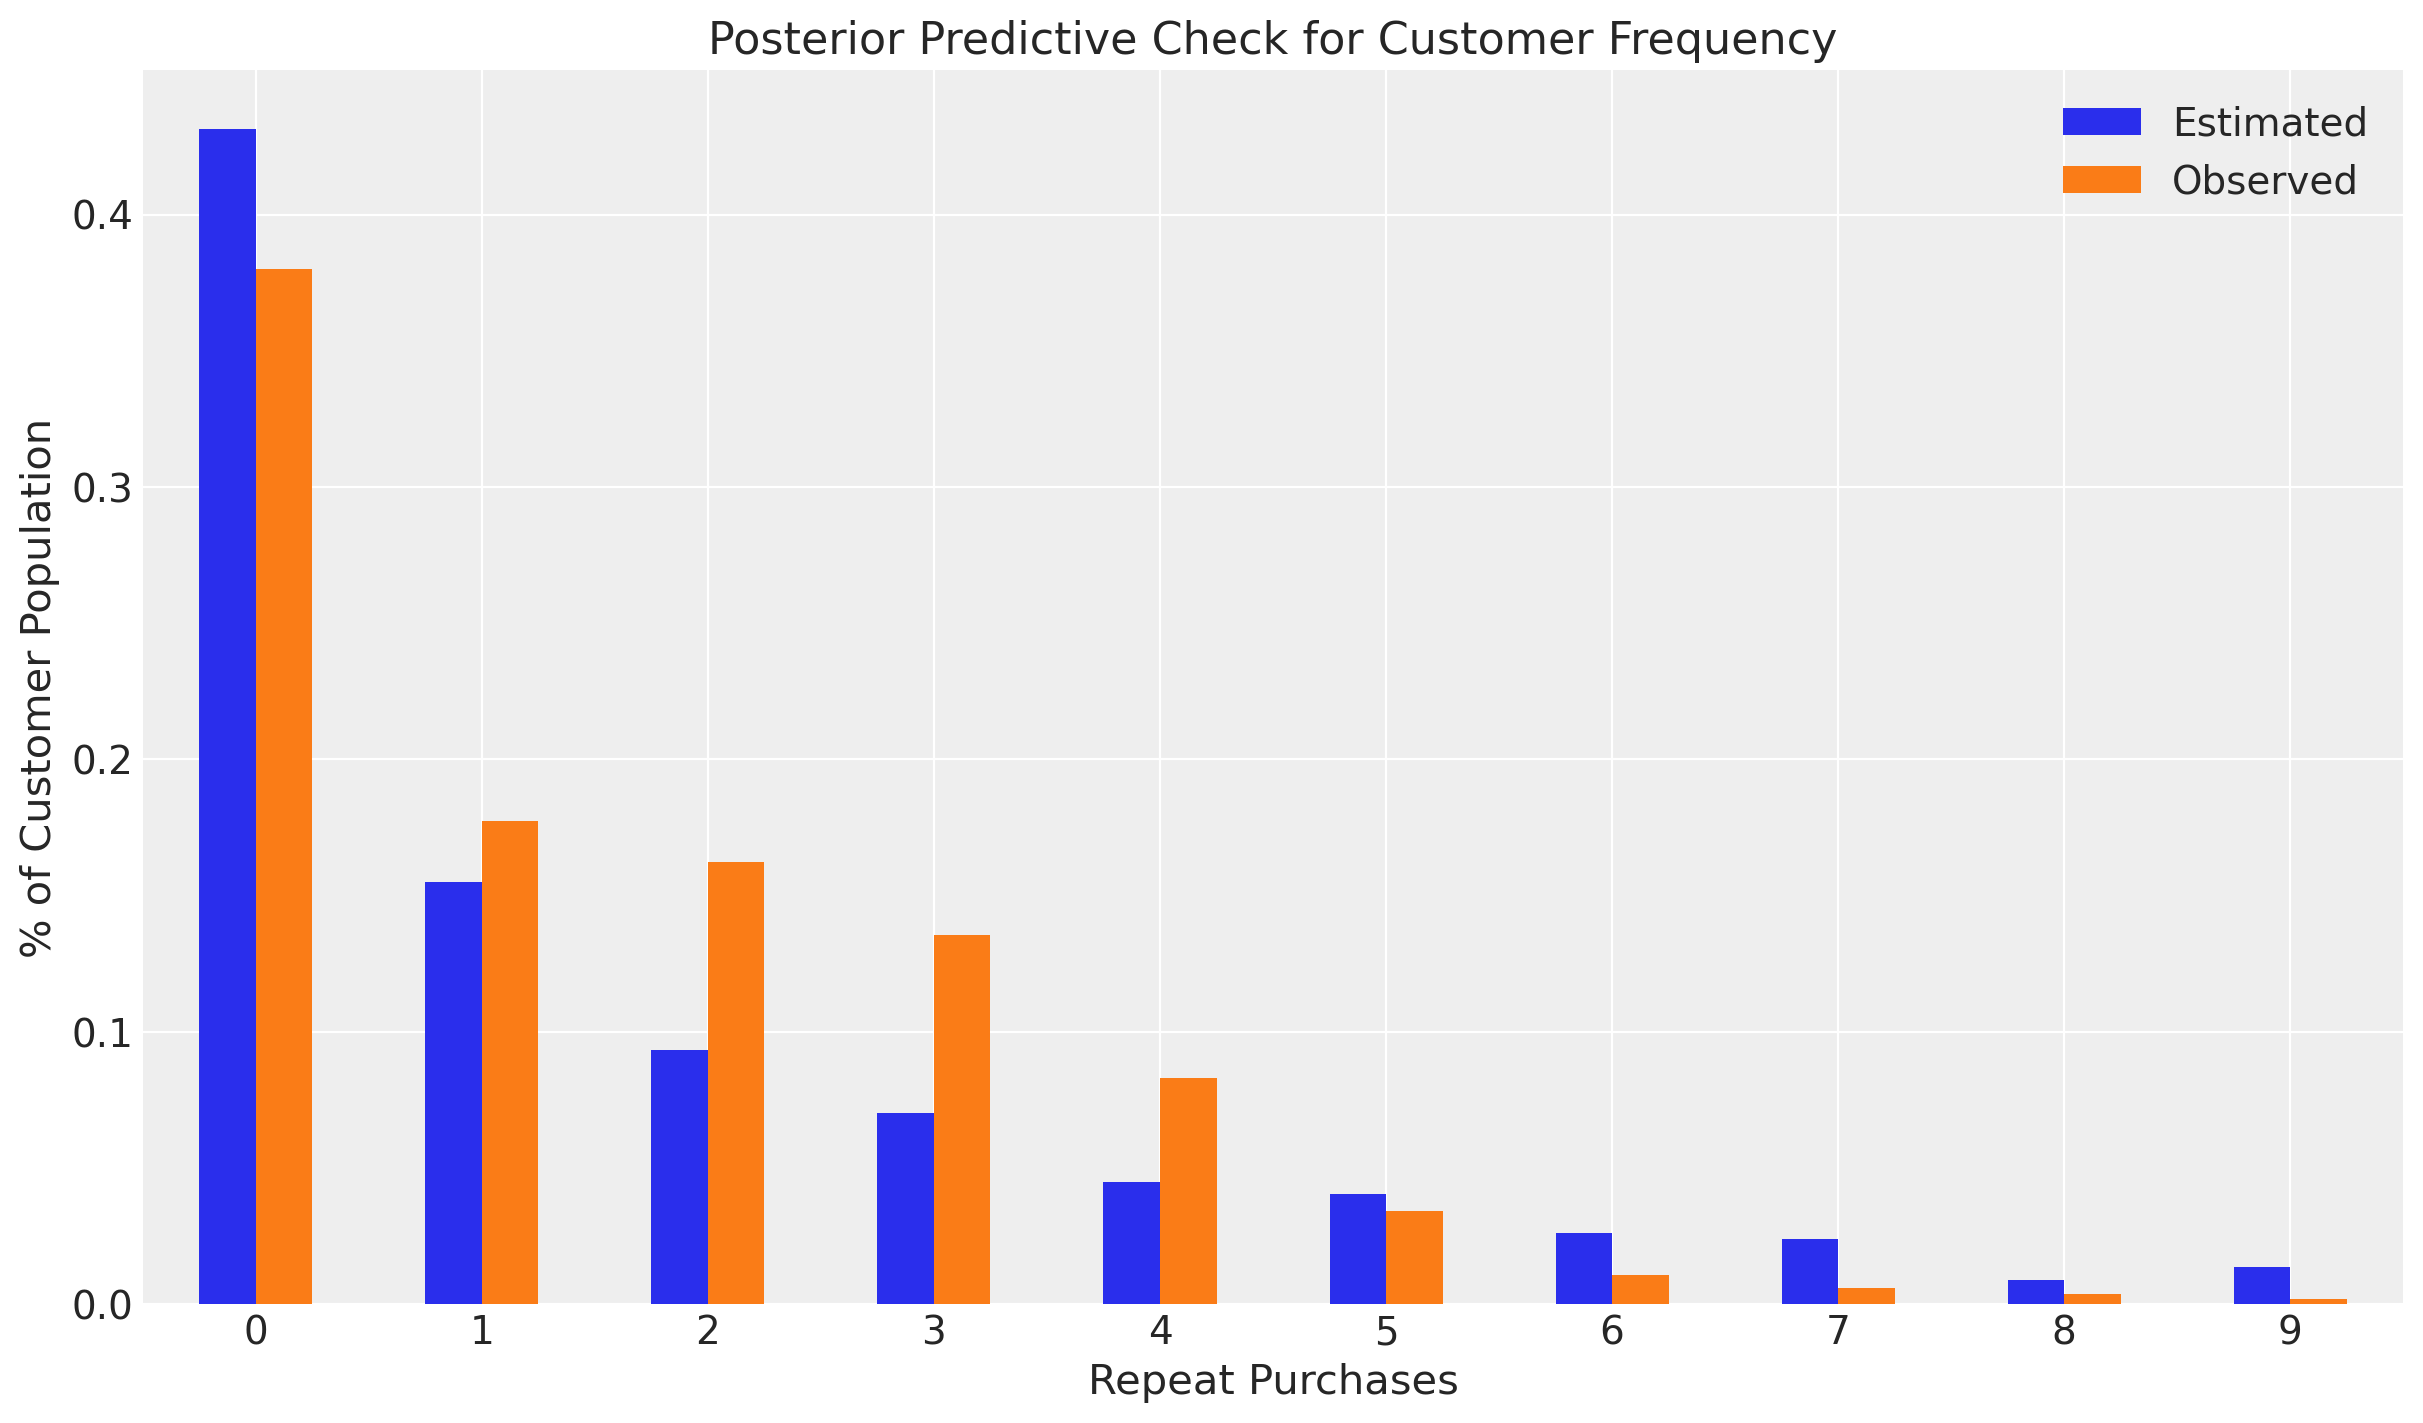

In [ ]:
pnbd_map.fit()
map_fit = pnbd_map.fit_summary()  # save for plotting later

obs_freq = pnbd_map.idata.observed_data["recency_frequency"].sel(obs_var="frequency")
ppc_freq = pnbd_map.distribution_new_customer_recency_frequency(
    data,
    random_seed=42,
).sel(chain=0, draw=0, obs_var="frequency")

# PPC histogram plot
clv.plot_expected_purchases_ppc(pnbd_map, ppc="posterior")

The model performed badly overall. However, for the 0th, 1st, and 5th repeat purchases, it was quite better.

In [21]:
pnbd_full = clv.ParetoNBDModel(data=data)
pnbd_full.fit(
    method="demz", draws=5000, tune=3000, idata_kwargs={"log_likelihood": True}
)

Multiprocess sampling (2 chains in 2 jobs)
DEMetropolisZ: [alpha, beta, r, s]


Output()

Sampling 2 chains for 3_000 tune and 5_000 draw iterations (6_000 + 10_000 draws total) took 161 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> fit_data

In [22]:
pnbd_full.fit_summary()

[autoreload of cutils_ext failed: Traceback (most recent call last):
  File "c:\Users\takue\anaconda3\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\takue\anaconda3\Lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "c:\Users\takue\anaconda3\Lib\importlib\__init__.py", line 130, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'cutils_ext'
]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,148.694,4.660,139.948,157.113,0.182,0.103,659.0,885.0,1.0
beta,9.645,4.643,1.524,17.853,0.174,0.100,658.0,692.0,1.0
r,0.456,0.013,0.431,0.480,0.000,0.000,733.0,1286.0,1.0
s,0.001,0.001,0.000,0.002,0.000,0.000,704.0,847.0,1.0


In [23]:
pnbd_full.thin_fit_result(keep_every=2).idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> fit_data

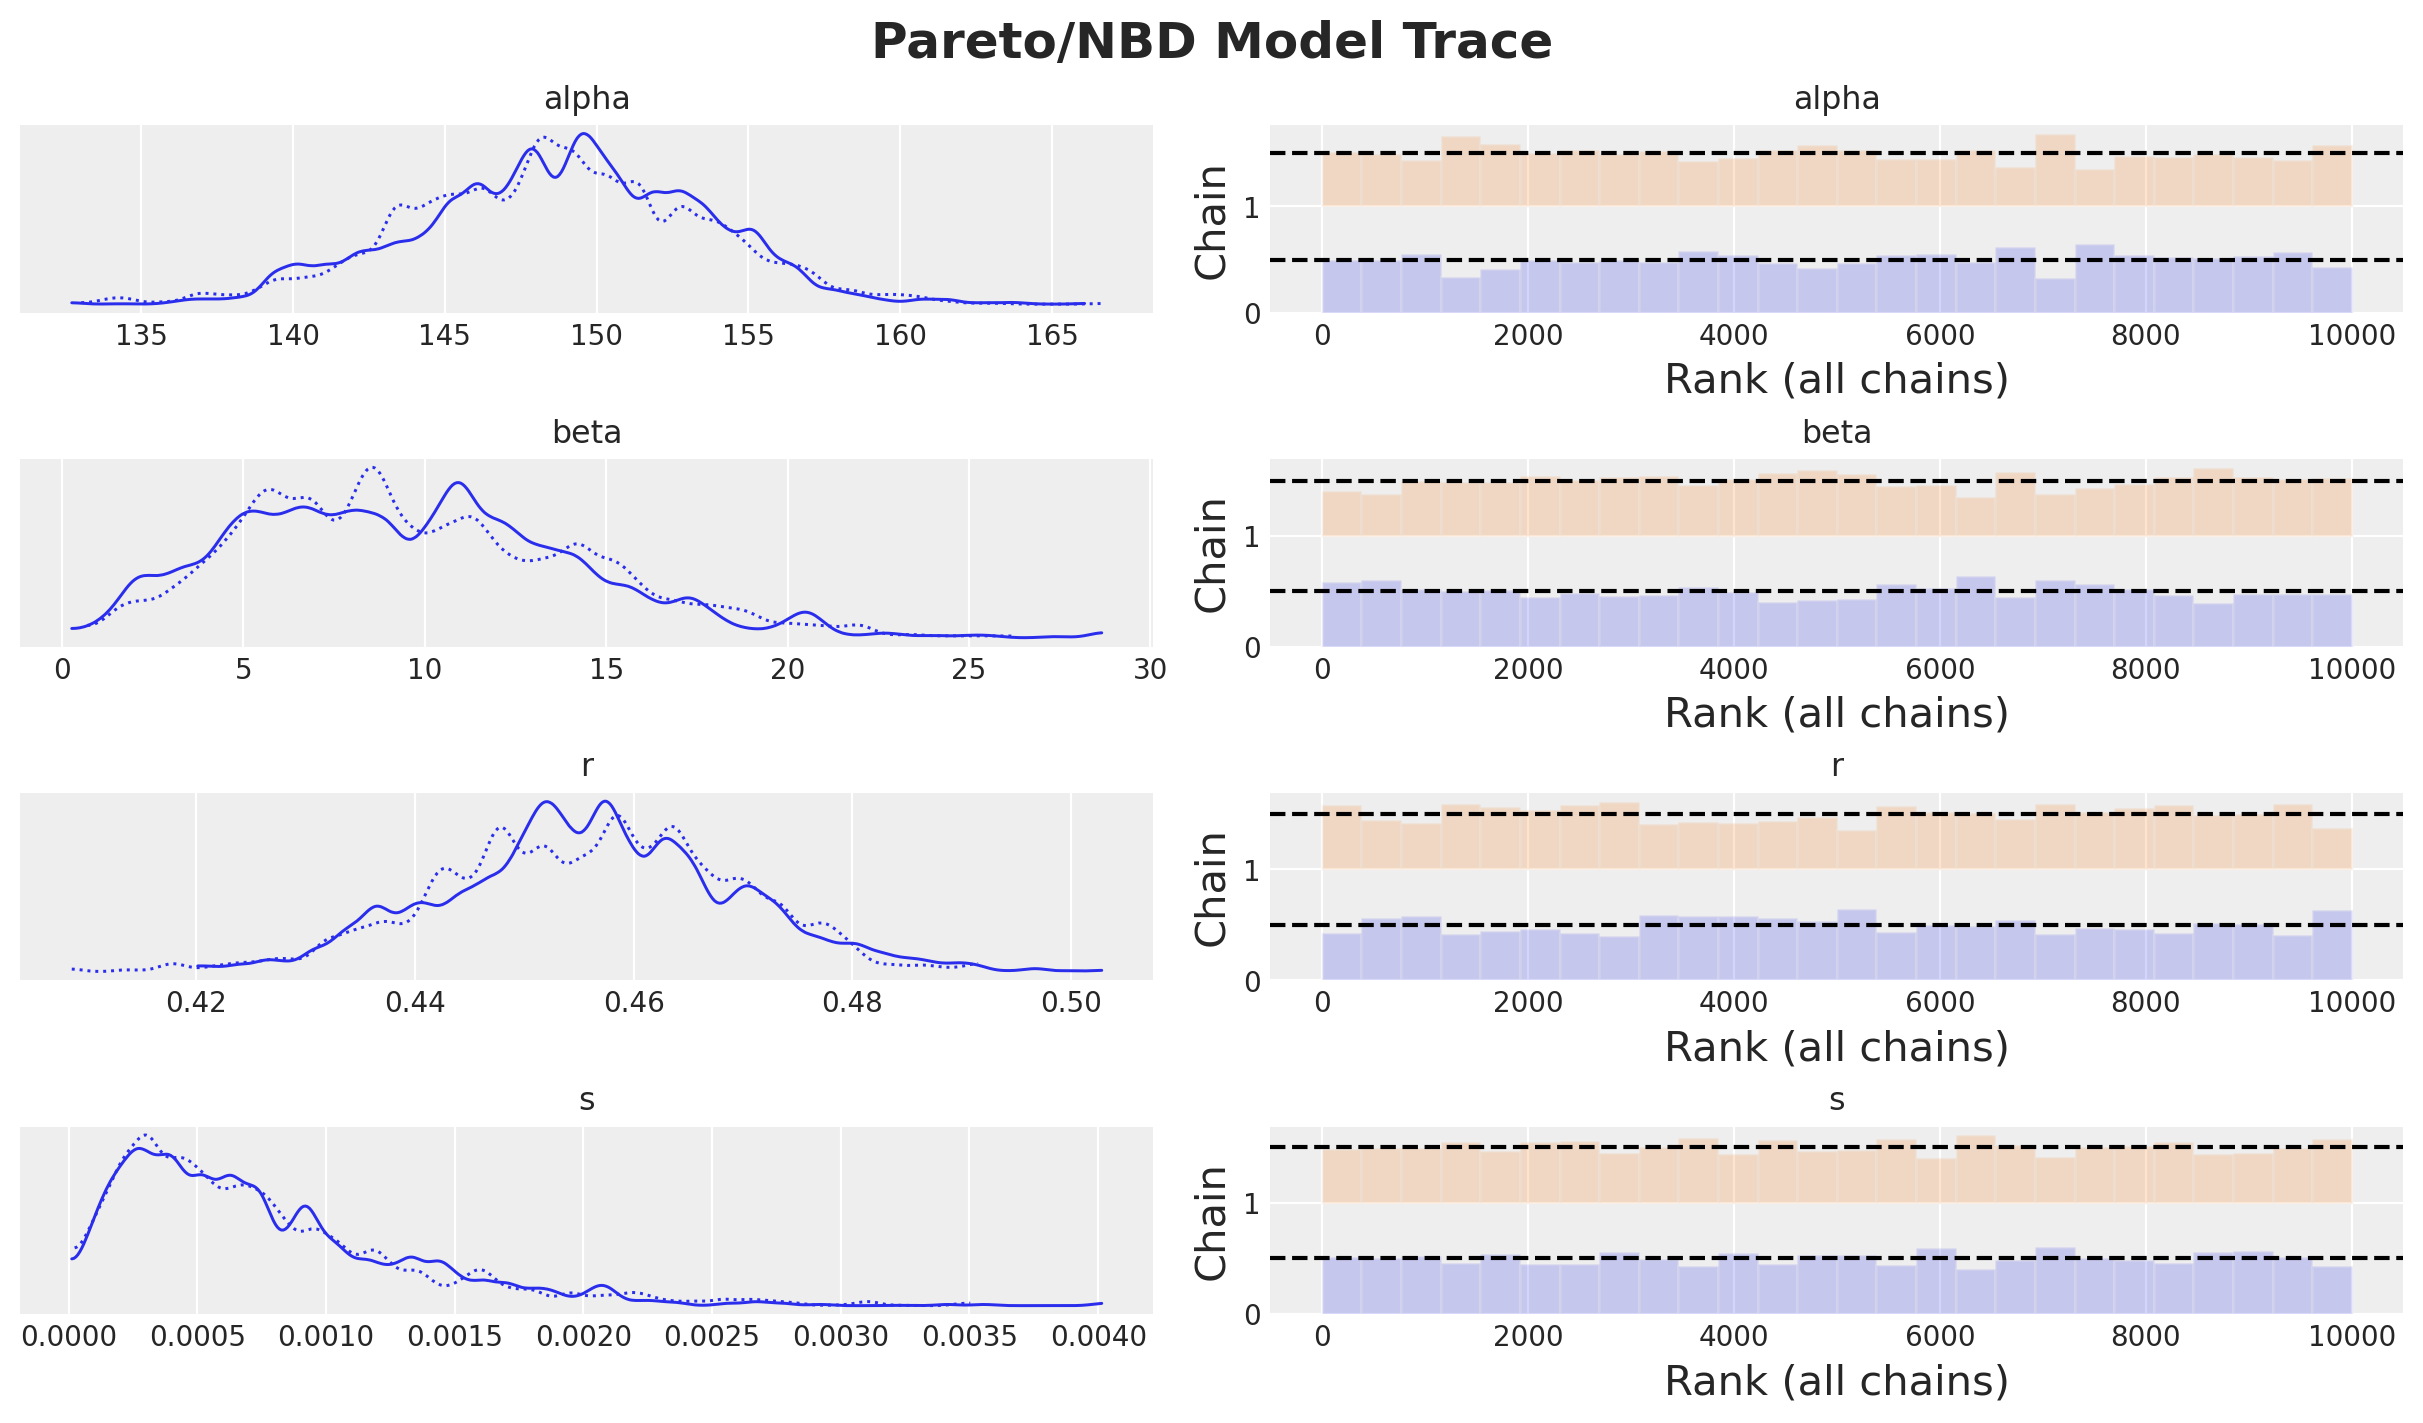

In [24]:
axes = az.plot_trace(
    data=pnbd_full.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Pareto/NBD Model Trace", fontsize=18, fontweight="bold");

In [25]:
pnbd_full.idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> fit_data

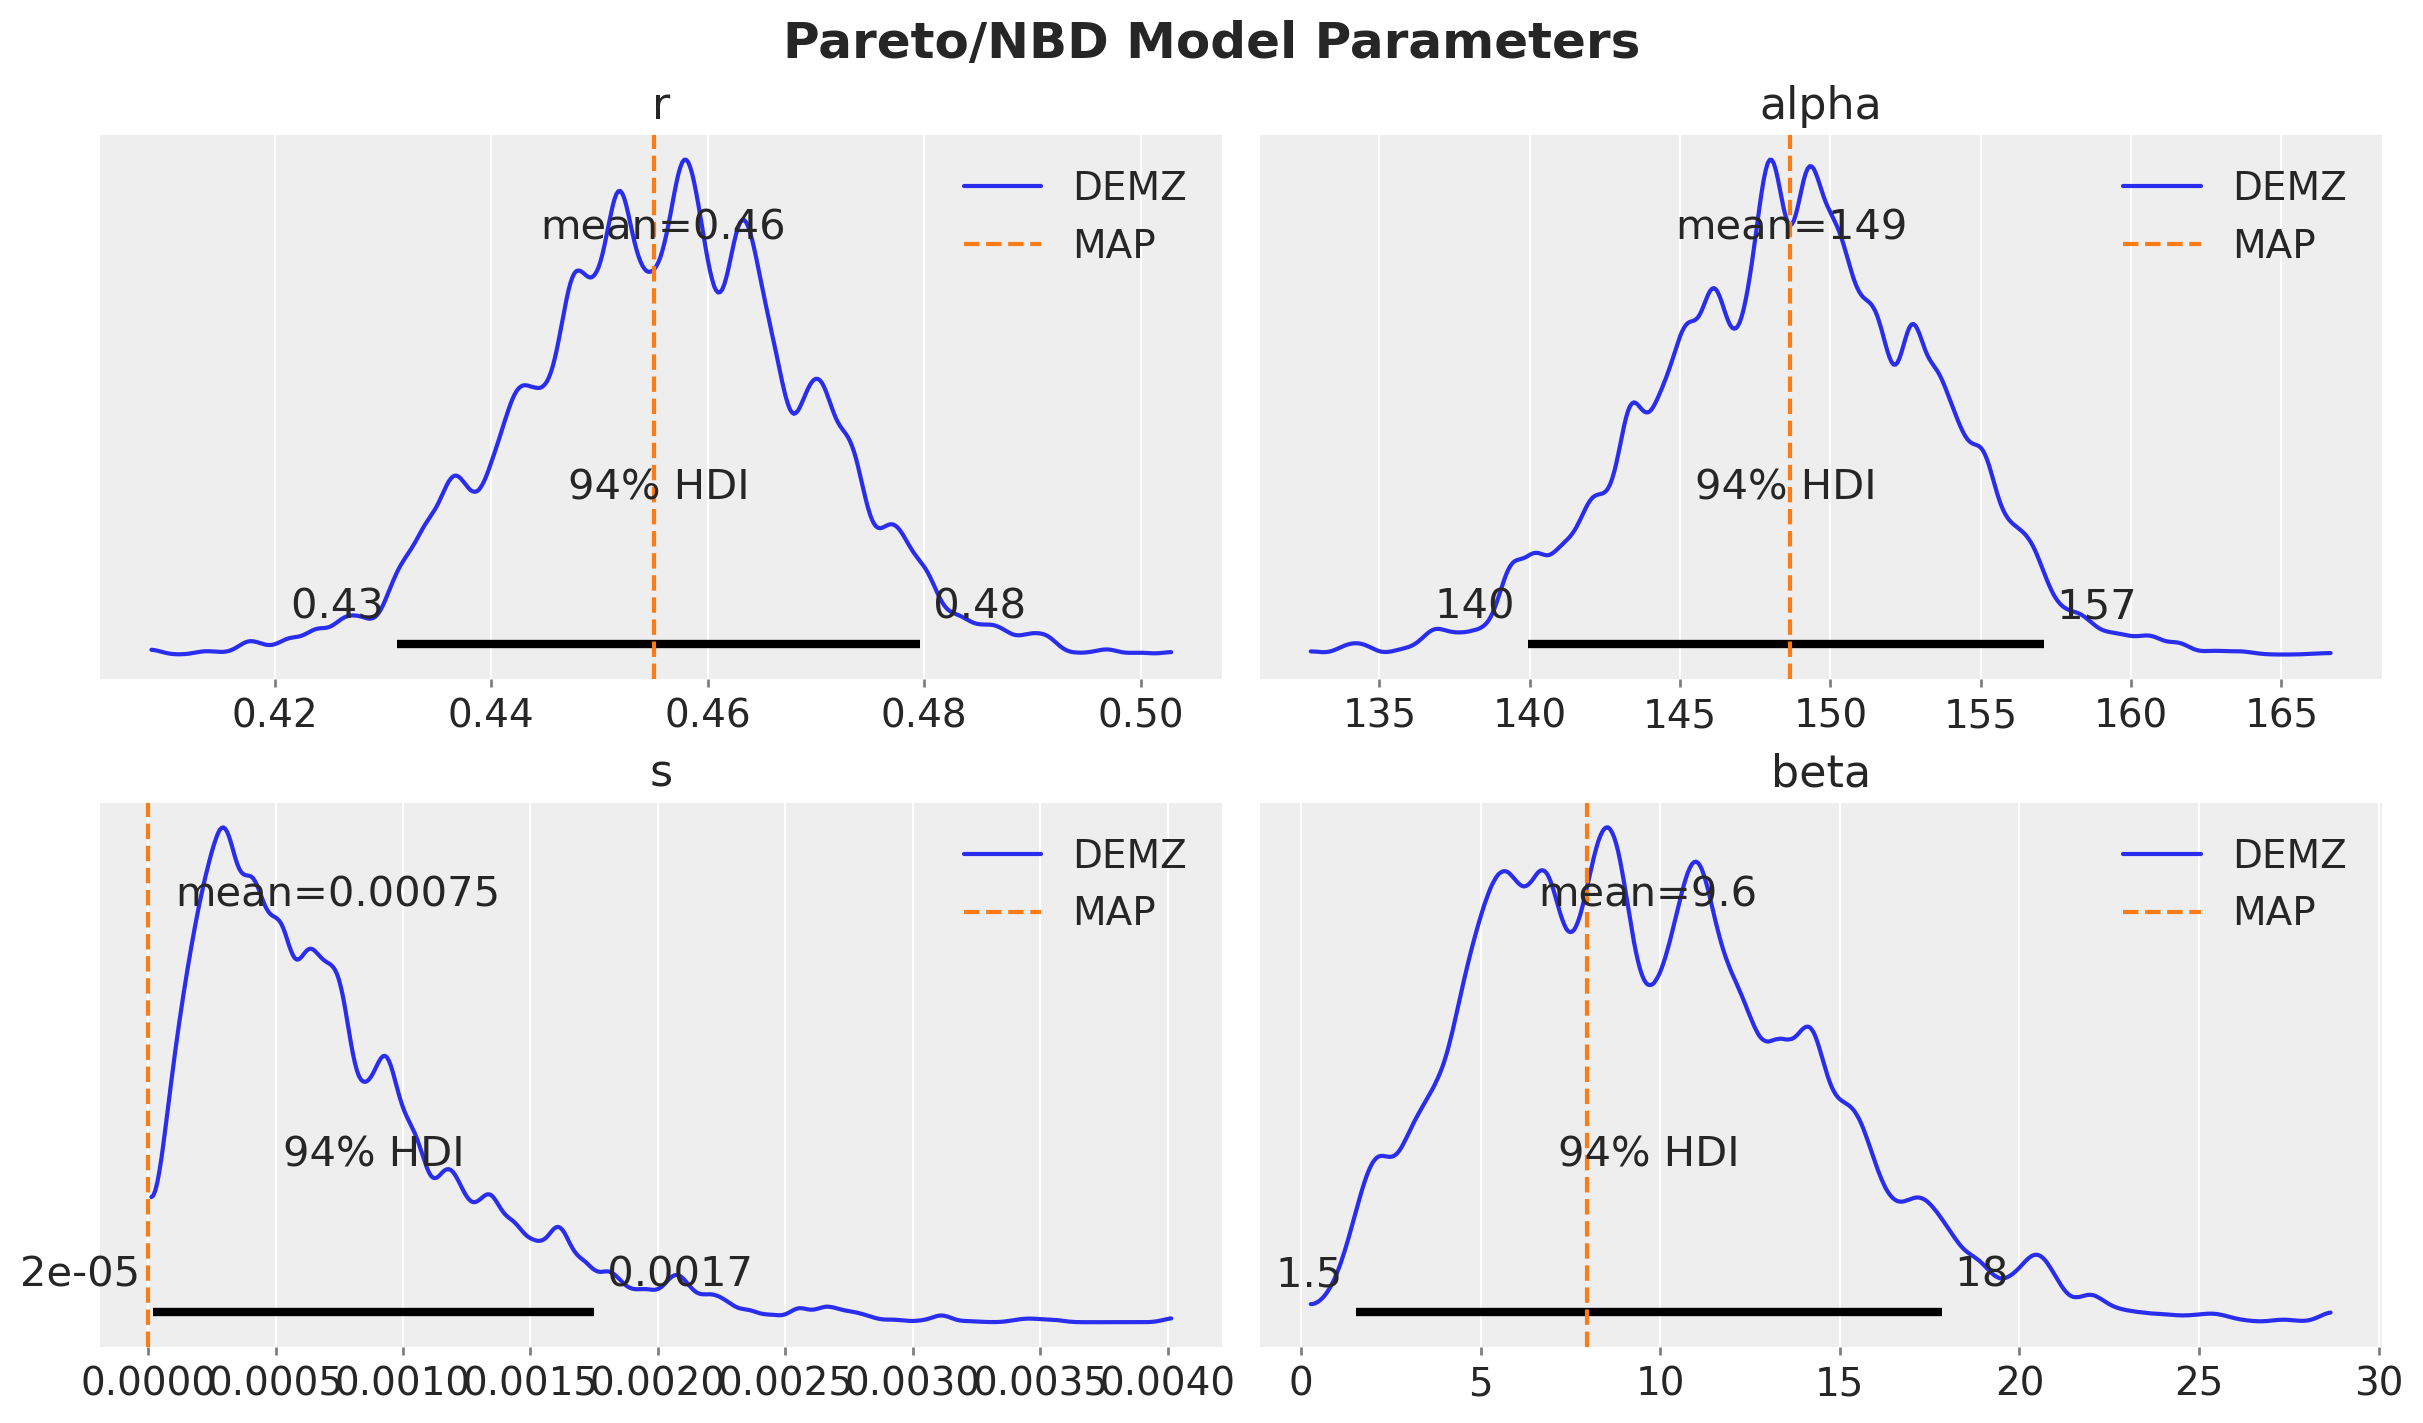

In [26]:
_, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 7), sharex=False, sharey=False, layout="constrained"
)

axes = axes.flatten()

for i, var_name in enumerate(["r", "alpha", "s", "beta"]):
    ax = axes[i]
    az.plot_posterior(
        pnbd_full.idata.posterior[var_name].values.flatten(),
        color="C0",
        point_estimate="mean",
        ax=ax,
        label="DEMZ",
    )
    ax.axvline(x=map_fit[var_name], color="C1", linestyle="--", label="MAP")
    ax.legend(loc="upper right")
    ax.set_title(var_name)

plt.gcf().suptitle("Pareto/NBD Model Parameters", fontsize=18, fontweight="bold");

In [27]:
# Save the inference data to a NetCDF file
pnbd_full.idata.to_netcdf("pnbd_model.nc")

'pnbd_model.nc'

In [37]:
# example customers
import random as rm
example_customer_ids = [1047, 1255, 1487, 1241, 10]

rfm_sample = data.query("customer_id.isin(@example_customer_ids)")

rfm_sample.sort_values(by="frequency")

,customer_id,recency,frequency,monetary_value,T
0,10,0,0,0.00,819
43,1047,0,0,0.00,1222
235,1255,0,0,0.00,232
446,1487,512,2,1191.43,973
223,1241,944,3,3227.77,1202


## Expected Number of Purchases

In [38]:
# Calculate expected number of purchases over time
time_periods = 365

expected_purchases_over_time = xr.concat(
    objs=[
        pnbd_full.expected_purchases(
            data=rfm_sample,
            future_t=t,
        )
        for t in progress_bar(range(time_periods))
    ],
    dim="t"
).transpose(..., "t")

# Display or use the results (e.g., mean expected purchases)
mean_expected_purchases = expected_purchases_over_time.mean(dim=["chain", "draw"])
print(mean_expected_purchases)

<xarray.DataArray (customer_id: 5, t: 365)> Size: 15kB
array([[0.00000000e+00, 4.68198189e-04, 9.36395960e-04, ...,
        1.69463631e-01, 1.69931703e-01, 1.70399775e-01],
       [0.00000000e+00, 3.30091797e-04, 6.60183395e-04, ...,
        1.19481347e-01, 1.19811376e-01, 1.20141405e-01],
       [0.00000000e+00, 2.55795399e-03, 5.11590640e-03, ...,
        9.25885510e-01, 9.28442966e-01, 9.31000421e-01],
       [0.00000000e+00, 1.19357066e-03, 2.38713767e-03, ...,
        4.31904163e-01, 4.33096923e-01, 4.34289681e-01],
       [0.00000000e+00, 2.18733160e-03, 4.37466154e-03, ...,
        7.91717026e-01, 7.93903847e-01, 7.96090666e-01]])
Coordinates:
  * customer_id  (customer_id) int32 20B 10 1047 1241 1255 1487
Dimensions without coordinates: t


Text(0.5, 0.98, 'Expected Number of Purchases')

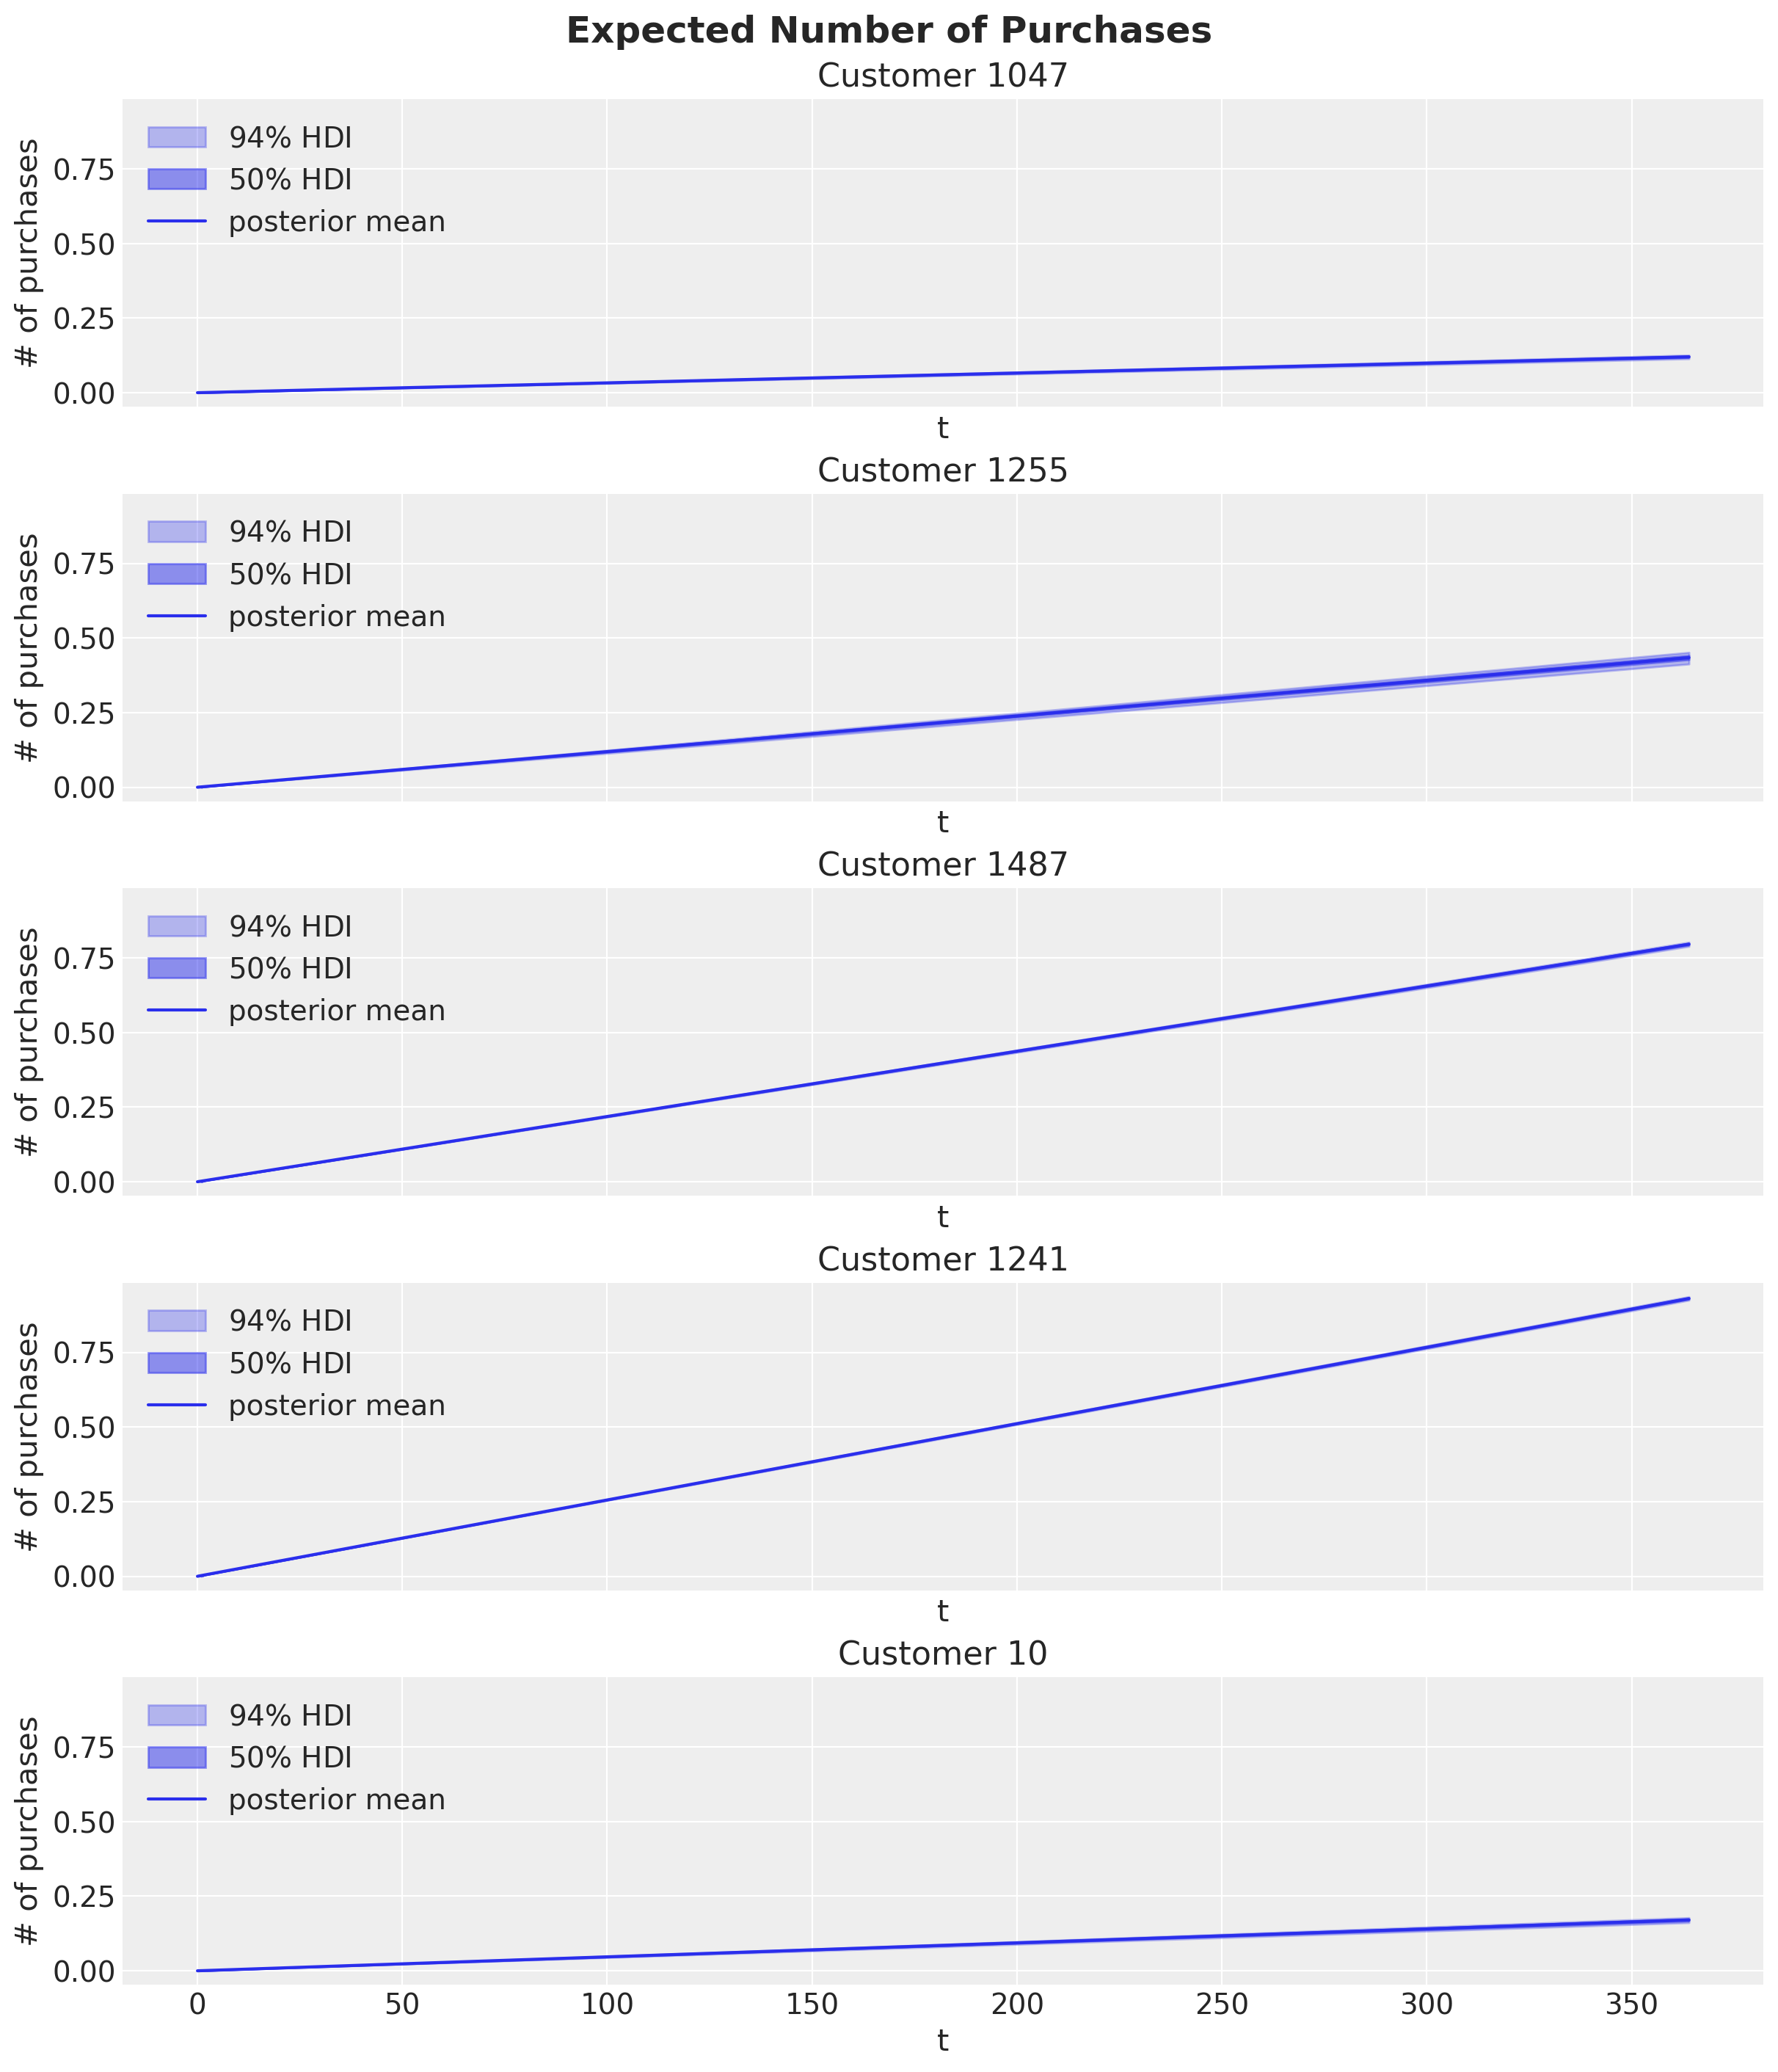

In [39]:
_, axes = plt.subplots(
    nrows=len(example_customer_ids),
    ncols=1,
    figsize=(12, 14),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.flatten()

for i, customer_id in enumerate(example_customer_ids):
    ax = axes[i]
    customer_expected_purchases = expected_purchases_over_time.sel(
        customer_id=customer_id
    )
    az.plot_hdi(
        range(time_periods),
        customer_expected_purchases,
        hdi_prob=0.94,
        color="C0",
        fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
        ax=ax,
    )
    az.plot_hdi(
        range(time_periods),
        customer_expected_purchases,
        hdi_prob=0.5,
        color="C0",
        fill_kwargs={"alpha": 0.5, "label": "$50 \\%$ HDI"},
        ax=ax,
    )
    ax.plot(
        range(time_periods),
        customer_expected_purchases.mean(dim=("chain", "draw")),
        color="C0",
        label="posterior mean",
    )
    ax.legend(loc="upper left")
    ax.set(title=f"Customer {customer_id}", xlabel="t", ylabel="# of purchases")

axes[-1].set(xlabel="t")
plt.gcf().suptitle("Expected Number of Purchases", fontsize=18, fontweight="bold")

All the customers have are more likely not to even make a single purchase in the coming year. This is understandable due to the nature of the business. 

### Expected Probability Alive

Text(0.5, 0.98, 'Expected Probability Alive')

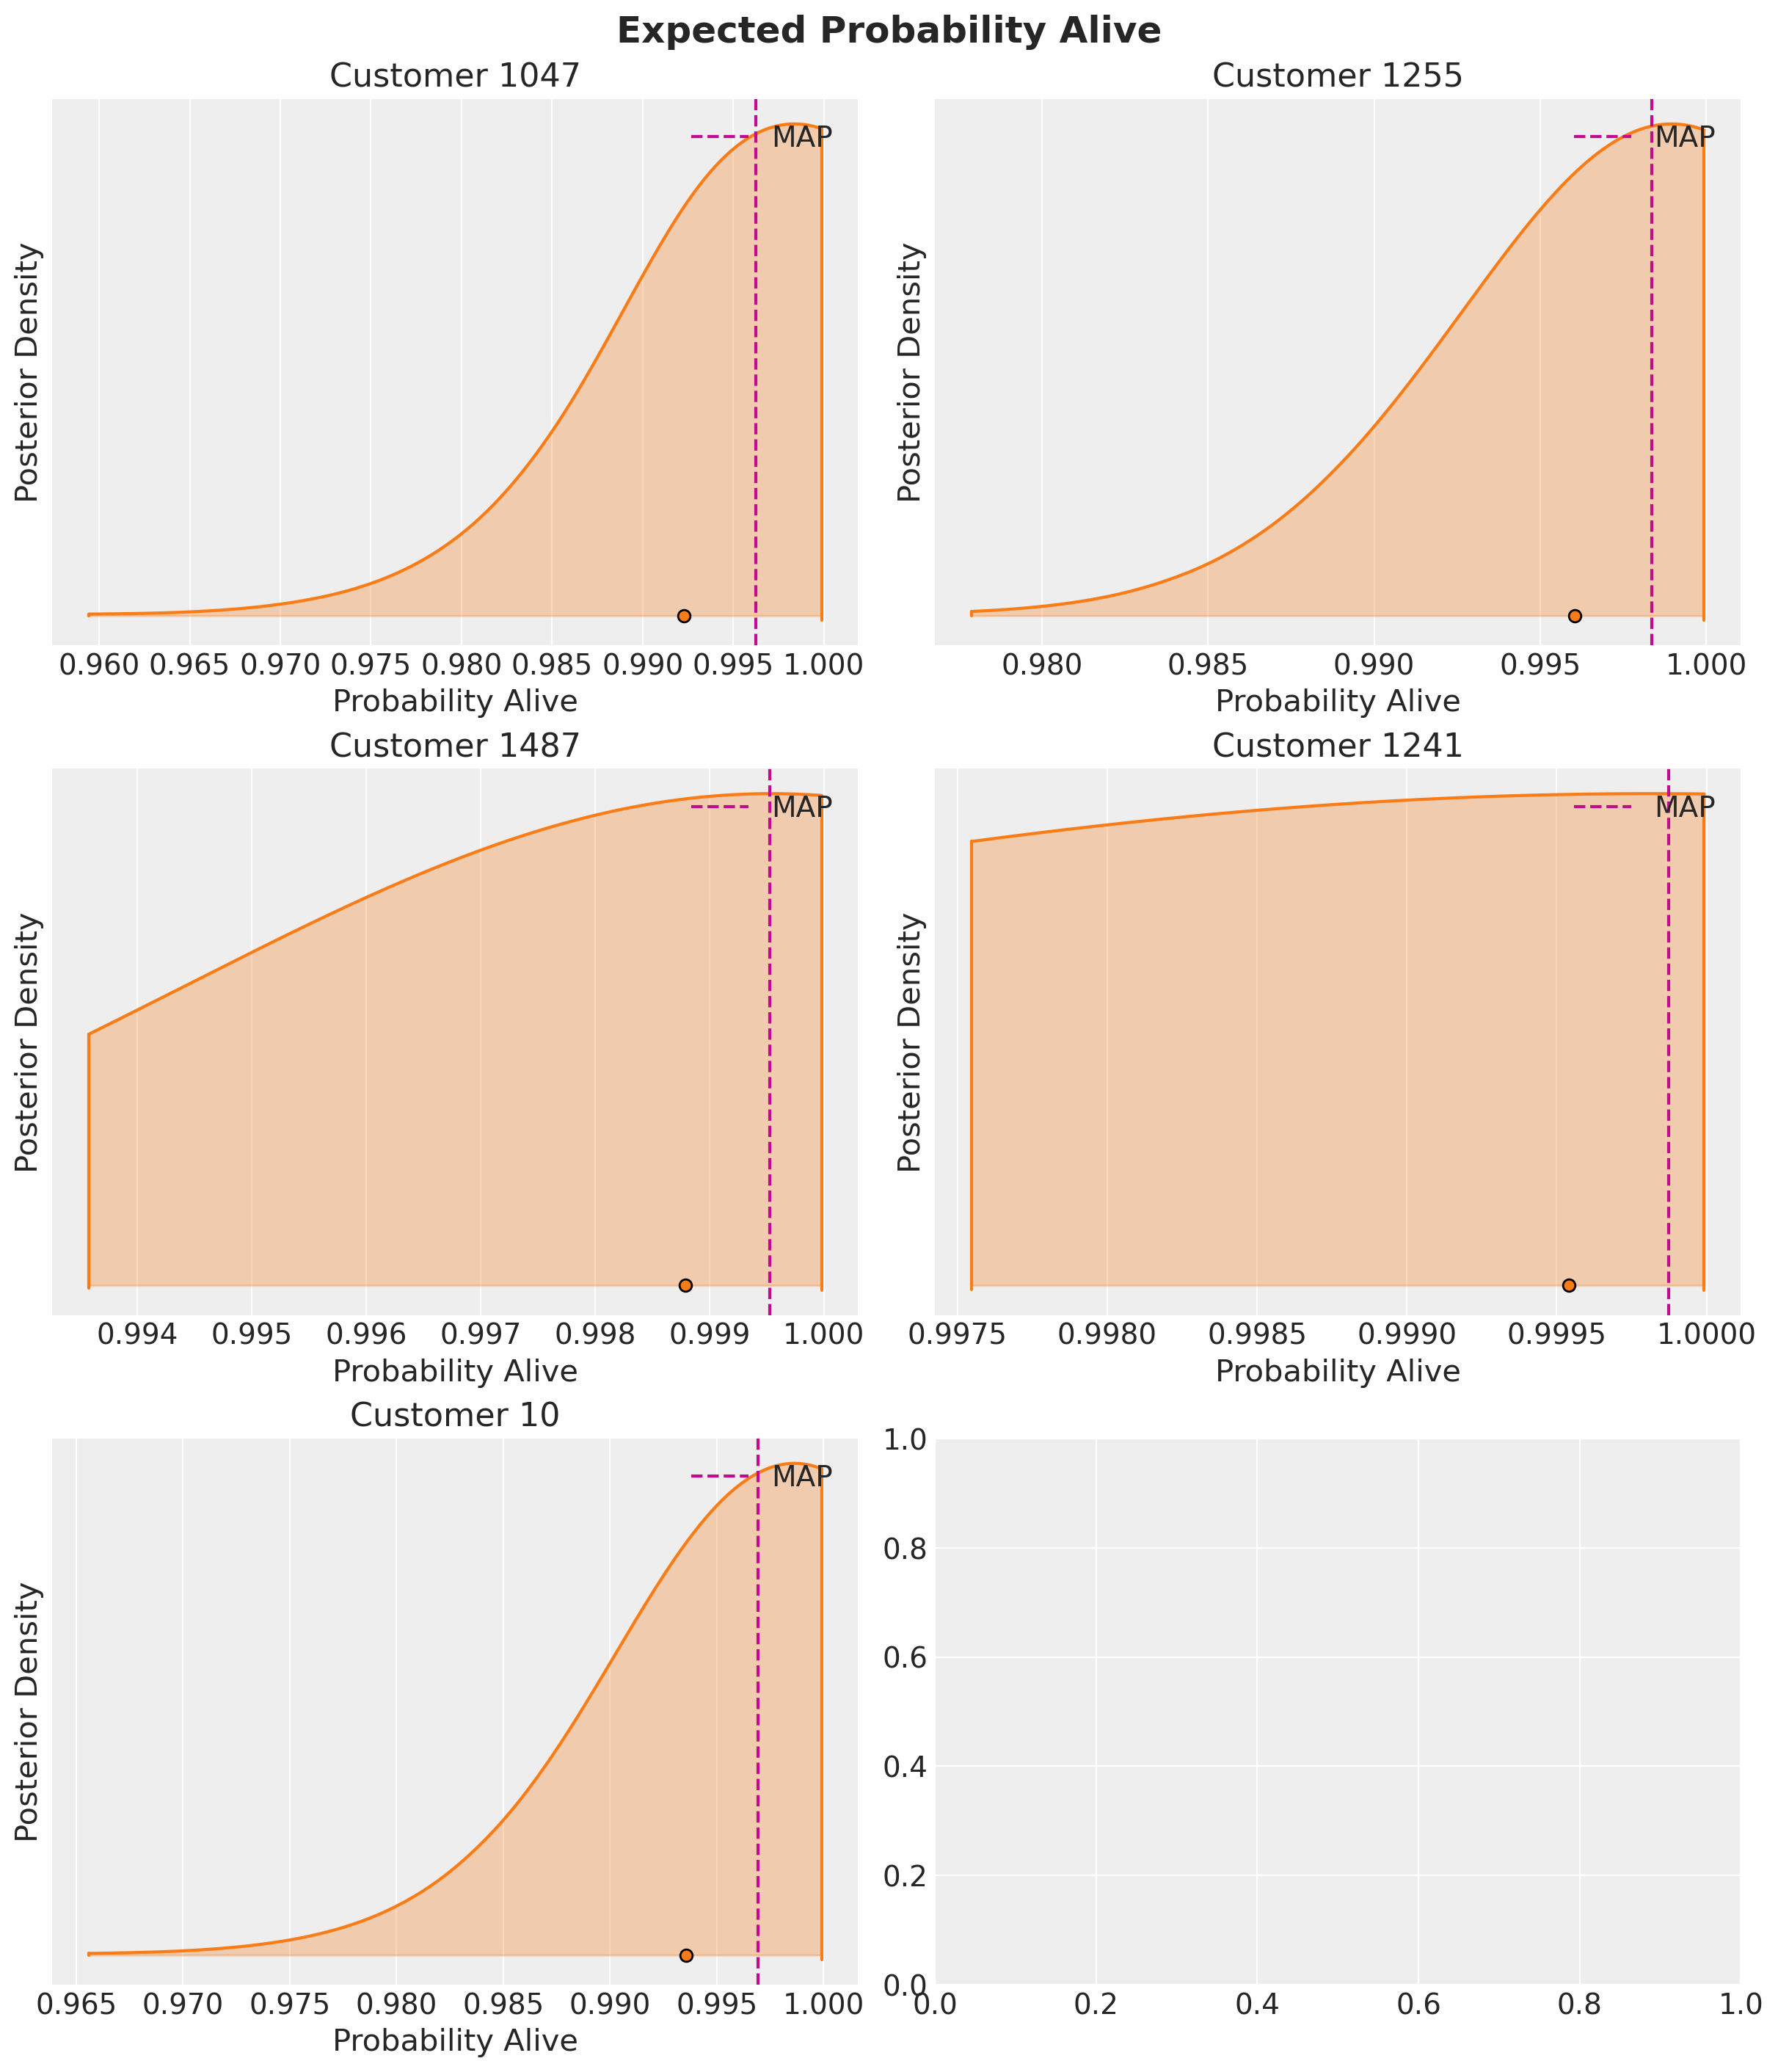

In [41]:
_, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(12, 14),
    layout="constrained",
)

axes = axes.flatten()

for i, customer_id in enumerate(example_customer_ids):
    ax = axes[i]
    demz_alive = pnbd_full.expected_probability_alive(
        rfm_sample,
        future_t=365,
    ).sel(customer_id=customer_id)
    map_alive = pnbd_map.expected_probability_alive(rfm_sample, future_t=0).sel(
        customer_id=customer_id
    )

    az.plot_density(demz_alive, hdi_prob=1, colors="C1", shade=0.3, bw=0.005, ax=ax)
    ax.axvline(x=map_alive, color="C3", linestyle="--", label="MAP")
    ax.legend(loc="upper right")
    ax.set(
        title=f"Customer {customer_id}",
        xlabel="Probability Alive",
        ylabel="Posterior Density",
    )

plt.gcf().suptitle("Expected Probability Alive", fontsize=18, fontweight="bold")

### Probability of n purchases over Time t

In [45]:
# create arrays of parameter combinations
n_purchases = np.repeat([0, 3, 6, 9, 12, 15], 6)
time_periods = np.tile([90, 180, 365, 730, 1825, 3680], 6)

expected_purchase_prob_heatmap = xr.concat(
    objs=[
        pnbd_map.expected_purchase_probability(
            rfm_sample,
            n_purchases=params[0],
            future_t=params[1],
        ).sel(customer_id=1487)
        for params in zip(n_purchases, time_periods, strict=False)
    ],
    dim="customer_id",
).transpose(..., "customer_id")

Text(0.5, 0.98, 'Expected Purchase Probabilities for Customer 1487')

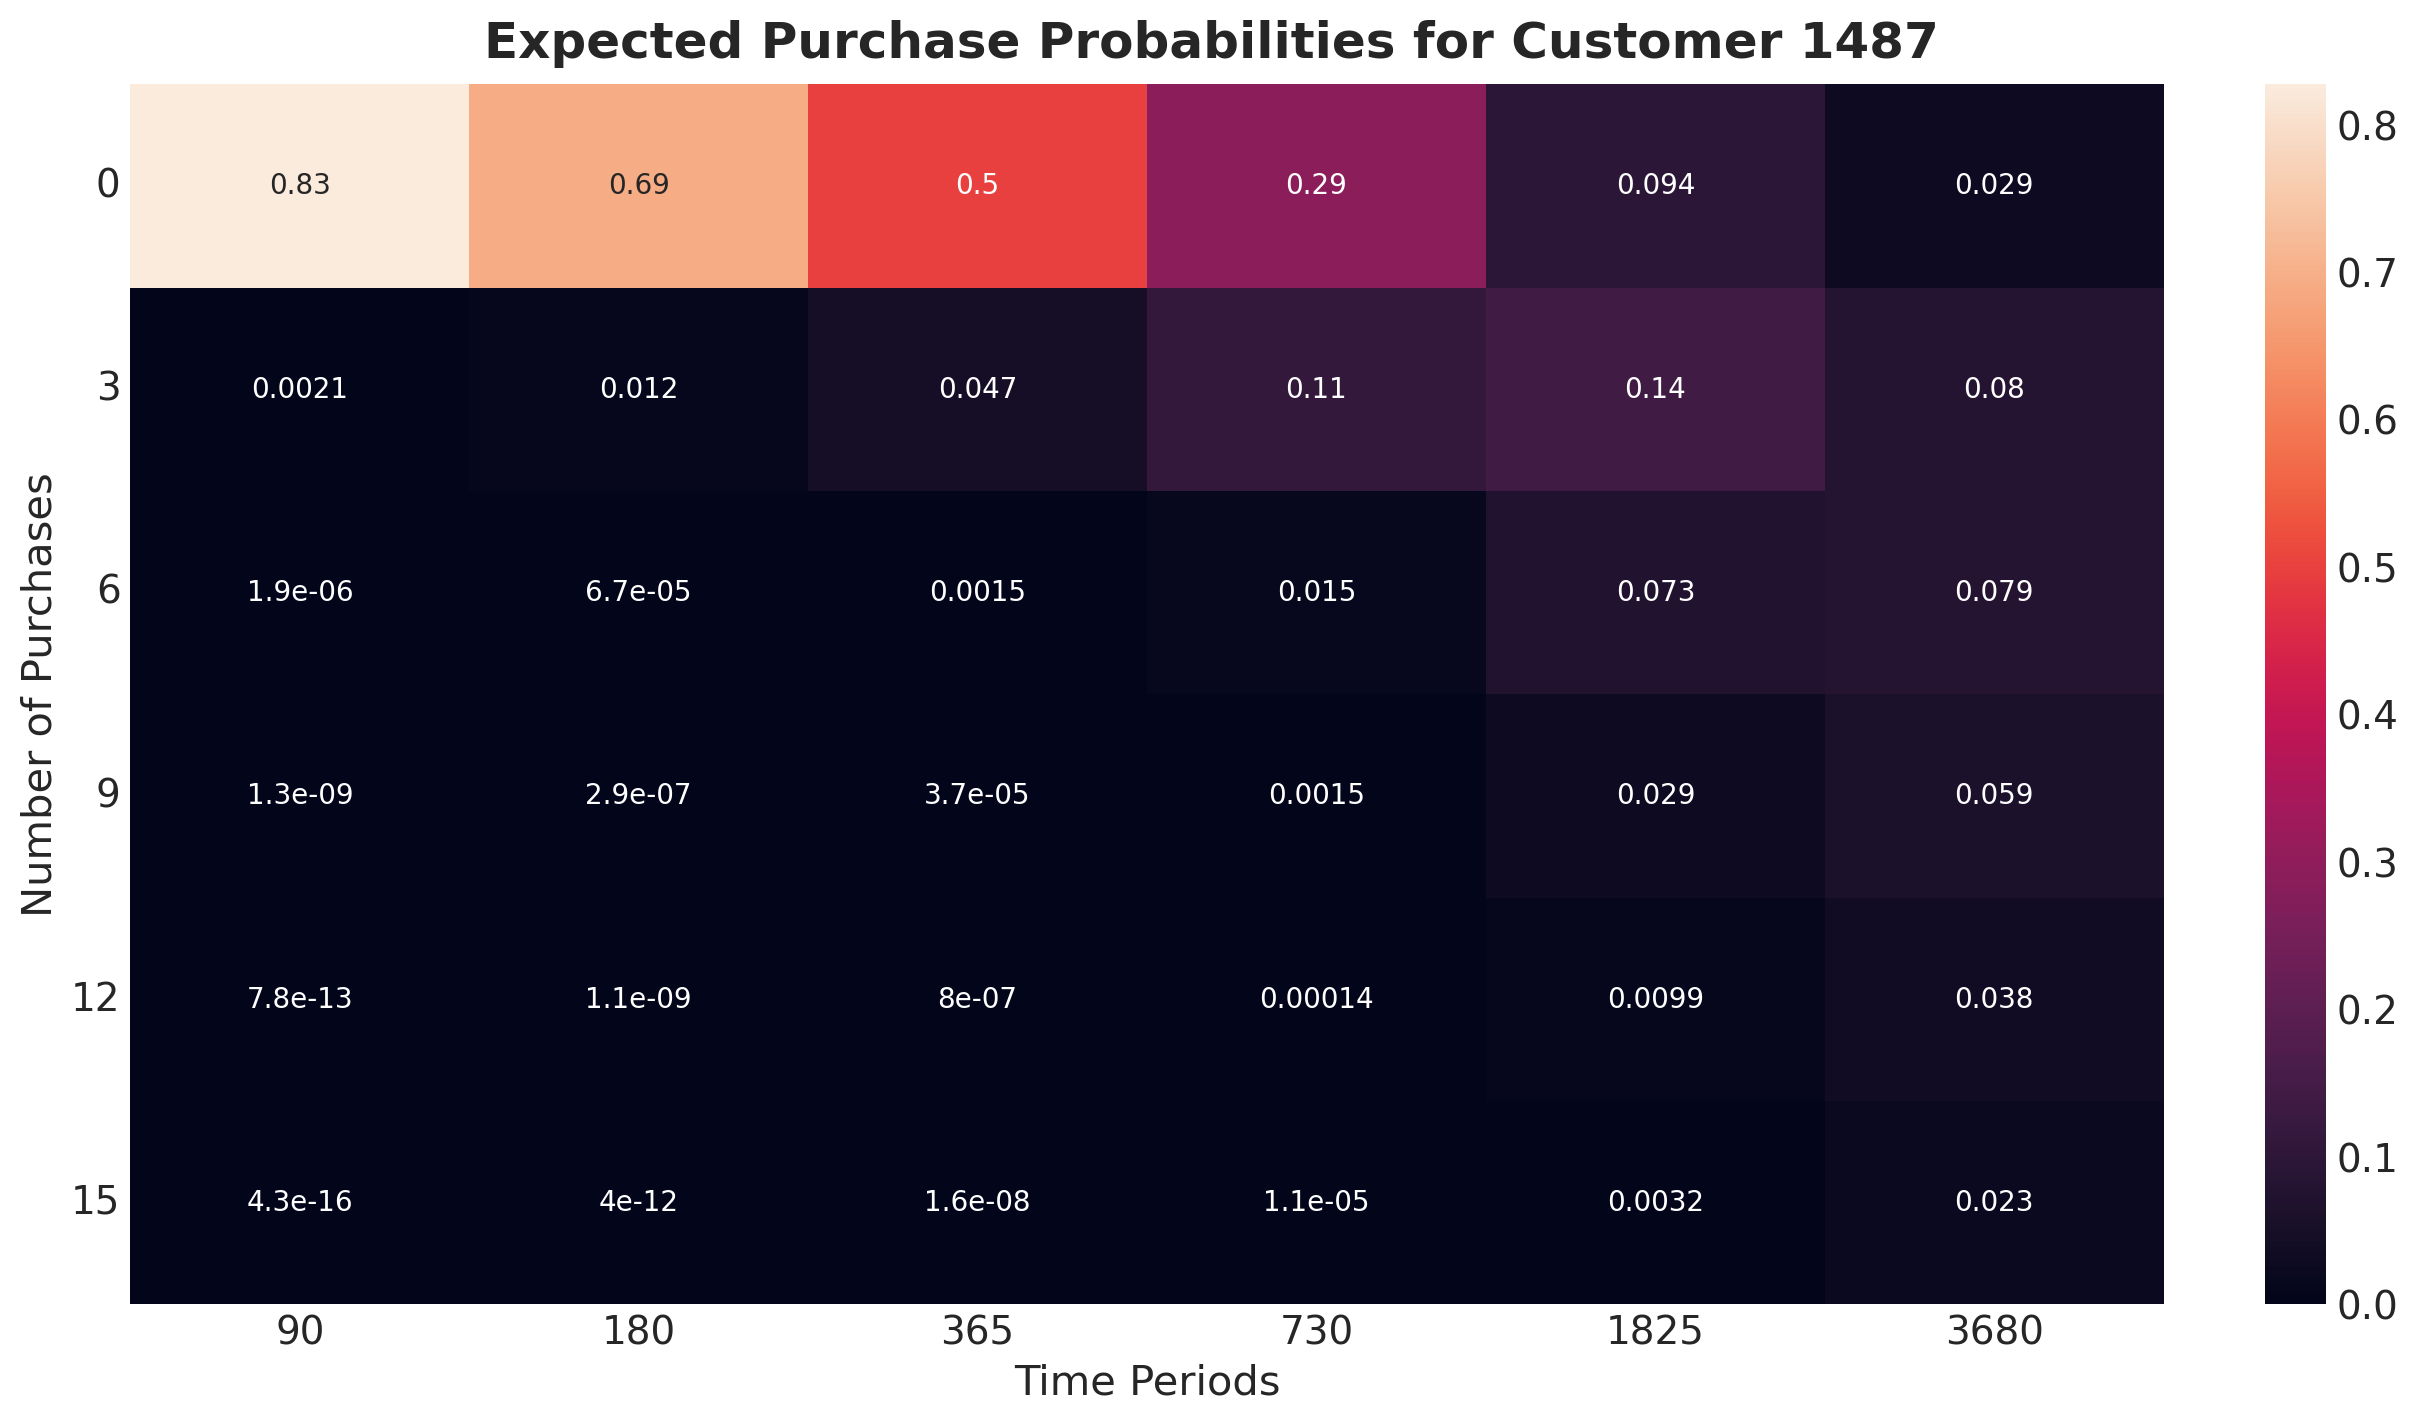

In [48]:
heatmap_reshape = expected_purchase_prob_heatmap.values.reshape(6, 6)

sb.heatmap(heatmap_reshape, annot=True)

plt.xlabel("Time Periods")
plt.xticks(np.arange(6) + 0.5, [90, 180, 365, 730, 1825, 3680], rotation=0)
plt.ylabel("Number of Purchases")
plt.yticks(np.arange(6) + 0.5, [0, 3, 6, 9, 12, 15], rotation=0)
plt.gcf().suptitle(
    "Expected Purchase Probabilities for Customer 1487", fontsize=18, fontweight="bold"
)